In [1]:
%pip install --quiet pandas numpy matplotlib scikit-learn lightgbm yfinance pandas_ta joblib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd, numpy as np, yfinance as yf

df_raw = yf.download("BTC-USD", period="5y", interval="1d", auto_adjust=False)
df_raw = df_raw.rename(columns=str.title).reset_index()[["Date","Open","High","Low","Close","Volume"]]
df_raw = df_raw.dropna()
print(df_raw.head(), df_raw.tail(), df_raw.shape, sep="\n\n")

[*********************100%***********************]  1 of 1 completed

Price        Date          Open          High           Low         Close  \
Ticker                  Btc-Usd       Btc-Usd       Btc-Usd       Btc-Usd   
0      2020-10-12  11392.635742  11698.467773  11240.686523  11555.363281   
1      2020-10-13  11548.719727  11548.984375  11321.224609  11425.899414   
2      2020-10-14  11429.047852  11539.977539  11307.831055  11429.506836   
3      2020-10-15  11426.602539  11569.914062  11303.603516  11495.349609   
4      2020-10-16  11502.828125  11540.061523  11223.012695  11322.123047   

Price        Volume  
Ticker      Btc-Usd  
0       26163972642  
1       24241420251  
2       24103426719  
3       24487233058  
4       25635480772  

Price        Date           Open           High            Low          Close  \
Ticker                   Btc-Usd        Btc-Usd        Btc-Usd        Btc-Usd   
1821   2025-10-07  124752.140625  125184.023438  120681.968750  121451.382812   
1822   2025-10-08  121448.351562  124167.093750  121119.179688

In [2]:
import pandas_ta as ta
import pandas as pd

# ----- CLEAN MULTIINDEX FROM YFINANCE -----
# yfinance sometimes returns ("Close","BTC-USD"), etc.
if isinstance(df_raw.columns, pd.MultiIndex):
    df_raw.columns = [c[0] for c in df_raw.columns]  # Take top level name only
    df_raw = df_raw.reset_index()

# Keep clean columns
df_raw = df_raw[["Date", "Open", "High", "Low", "Close", "Volume"]]

# ----- FEATURE ENGINEERING -----
df = df_raw.copy()
df["SMA20"] = ta.sma(df["Close"], length=20)
df["EMA50"] = ta.ema(df["Close"], length=50)
df["RSI14"] = ta.rsi(df["Close"], length=14)

bb = ta.bbands(df["Close"], length=20)
df = pd.concat([df, bb], axis=1)
df = df.rename(columns={"BBL_20_2.0":"BBL","BBM_20_2.0":"BBM","BBU_20_2.0":"BBU"})

# Target: next-day return
df["Ret1d"] = df["Close"].pct_change().shift(-1)

# Drop NaN rows
df = df.dropna().reset_index(drop=True)

# ----- SAVE -----
df.to_csv("feat_daily_clean.csv", index=False)
df.to_excel("feat_daily_clean.xlsx", index=False)

print("✅ Saved clean feature file -> feat_daily_clean.csv & feat_daily_clean.xlsx")
print(df.head())


✅ Saved clean feature file -> feat_daily_clean.csv & feat_daily_clean.xlsx
        Date          Open          High           Low         Close  \
0 2020-11-30  18178.322266  19749.263672  18178.322266  19625.835938   
1 2020-12-01  19633.769531  19845.974609  18321.921875  18802.998047   
2 2020-12-02  18801.744141  19308.330078  18347.718750  19201.091797   
3 2020-12-03  19205.925781  19566.191406  18925.785156  19445.398438   
4 2020-12-04  19446.966797  19511.404297  18697.193359  18699.765625   

        Volume         SMA20         EMA50      RSI14           BBL  \
0  47728480399  17595.942383  14974.546133  70.940956  15374.295385   
1  49633658712  17751.025293  15124.681502  62.816584  15650.309828   
2  37387697139  17897.262695  15284.540729  64.910347  15820.470602   
3  31930317405  18053.642188  15447.711620  66.169340  16005.311887   
4  33872388058  18185.223535  15575.243149  59.189242  16335.506619   

            BBM           BBU  BBB_20_2.0  BBP_20_2.0     Ret1d  

In [3]:
import pandas as pd
import numpy as np

# Load your saved dataset
df = pd.read_excel("feat_daily_clean.xlsx", parse_dates=["Date"])

print("🔍 Basic Info:")
print(df.info(), "\n")

# ---------------------------
# 1️⃣ Missing / Null Values
# ---------------------------
print("🚨 Missing value summary:")
print(df.isna().sum())
print("\nTotal rows:", len(df))
print("Rows with any missing values:", df.isna().any(axis=1).sum(), "\n")

# ---------------------------
# 2️⃣ Duplicate Dates
# ---------------------------
dupes = df["Date"].duplicated().sum()
print(f"🔁 Duplicate date entries: {dupes}")

# ---------------------------
# 3️⃣ Date Range & Continuity
# ---------------------------
df = df.sort_values("Date").reset_index(drop=True)
expected_dates = pd.date_range(start=df["Date"].min(), end=df["Date"].max(), freq="D")
missing_dates = expected_dates.difference(df["Date"])

print(f"📅 Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Total expected days: {len(expected_dates)}, present in file: {len(df)}")
if len(missing_dates) == 0:
    print("✅ No missing calendar dates (perfect daily continuity).")
else:
    print(f"⚠️ Missing {len(missing_dates)} dates:")
    print(missing_dates[:10])  # print first few only

# ---------------------------
# 4️⃣ Basic Statistical Overview
# ---------------------------
print("\n📊 Summary statistics for key columns:")
print(df[["Open","High","Low","Close","Volume","Ret1d"]].describe().T)

# ---------------------------
# 5️⃣ Sanity Checks
# ---------------------------
if (df["High"] < df["Low"]).any():
    print("⚠️ Some rows have High < Low!")
else:
    print("✅ High/Low relationship looks valid.")

if (df["Volume"] <= 0).any():
    print("⚠️ Some rows have non-positive volume.")
else:
    print("✅ All volumes are positive.")

if (abs(df["Ret1d"]) > 0.5).any():
    print("⚠️ Detected unusually large daily returns > 50%. Check data integrity.")
else:
    print("✅ Return magnitudes look reasonable (<50%).")


🔍 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1776 non-null   datetime64[ns]
 1   Open        1776 non-null   float64       
 2   High        1776 non-null   float64       
 3   Low         1776 non-null   float64       
 4   Close       1776 non-null   float64       
 5   Volume      1776 non-null   int64         
 6   SMA20       1776 non-null   float64       
 7   EMA50       1776 non-null   float64       
 8   RSI14       1776 non-null   float64       
 9   BBL         1776 non-null   float64       
 10  BBM         1776 non-null   float64       
 11  BBU         1776 non-null   float64       
 12  BBB_20_2.0  1776 non-null   float64       
 13  BBP_20_2.0  1776 non-null   float64       
 14  Ret1d       1776 non-null   float64       
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 

EDA

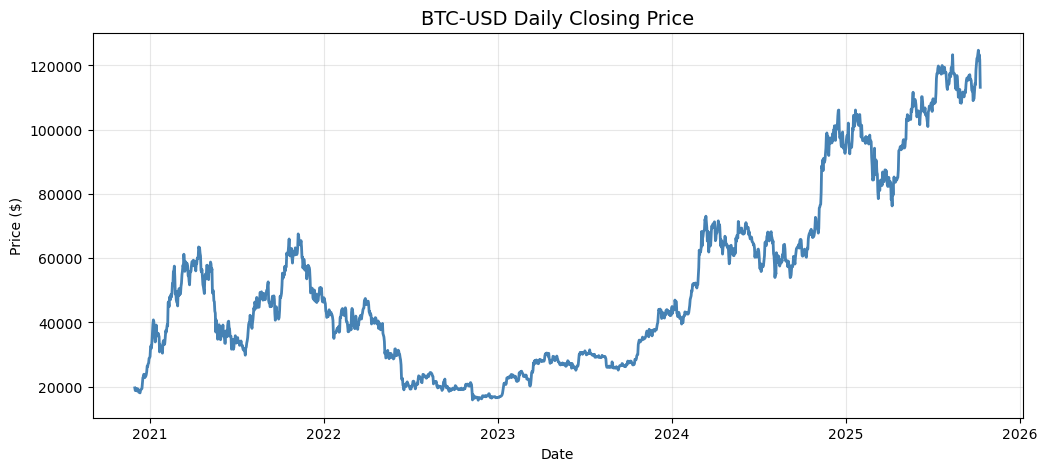

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Close"], color="steelblue", linewidth=2)
plt.title("BTC-USD Daily Closing Price", fontsize=14)
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.show()


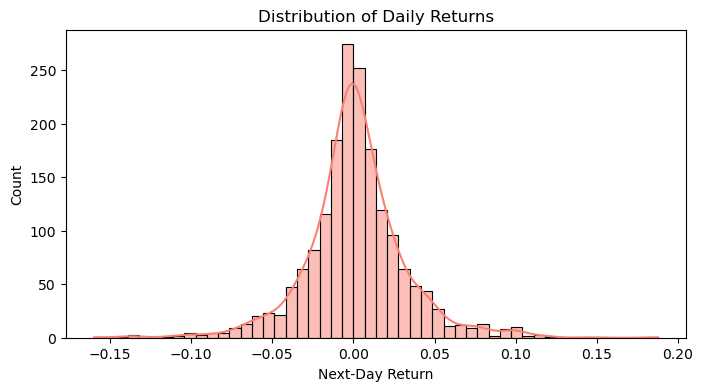

Mean daily return: 0.0014595071738276635
Std dev: 0.03103752103824868
Skewness: 0.13885957962232373
Kurtosis: 3.5785408009620805


In [5]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df["Ret1d"], bins=50, kde=True, color="salmon")
plt.title("Distribution of Daily Returns")
plt.xlabel("Next-Day Return")
plt.show()

print("Mean daily return:", df["Ret1d"].mean())
print("Std dev:", df["Ret1d"].std())
print("Skewness:", df["Ret1d"].skew())
print("Kurtosis:", df["Ret1d"].kurt())


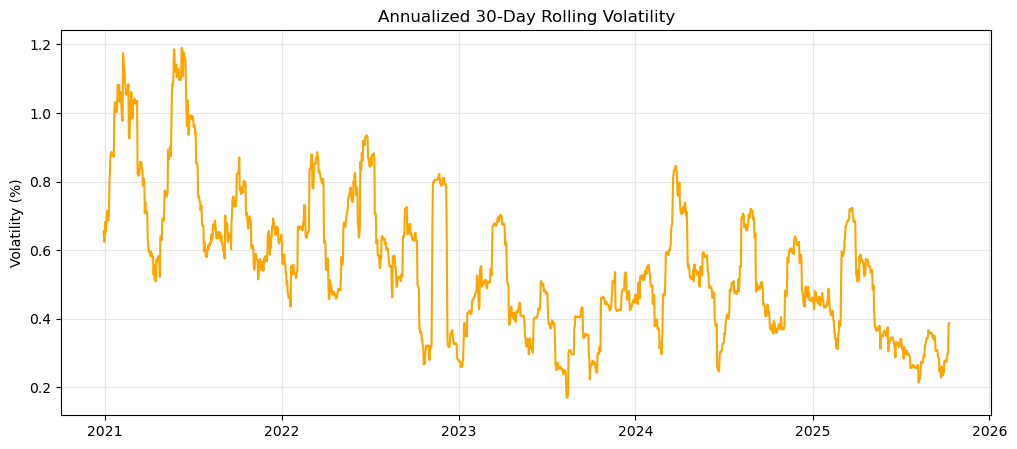

In [6]:
df["RollingVol"] = df["Ret1d"].rolling(30).std() * (365**0.5)
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["RollingVol"], color="orange")
plt.title("Annualized 30-Day Rolling Volatility")
plt.ylabel("Volatility (%)")
plt.grid(alpha=0.3)
plt.show()


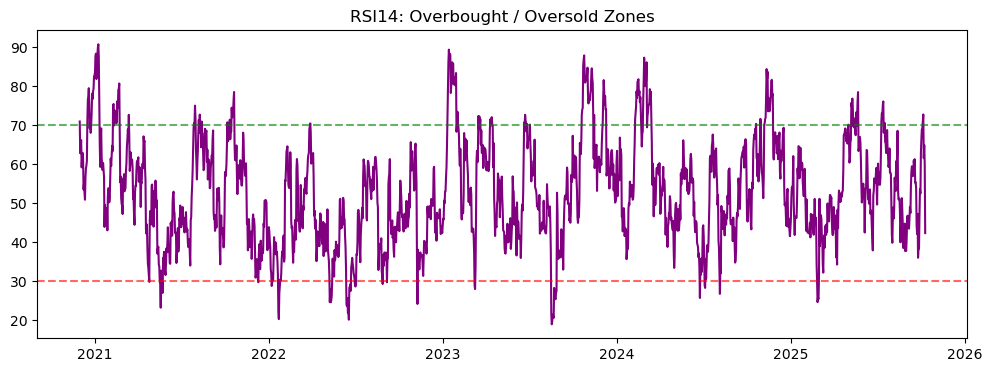

In [7]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["RSI14"], color="purple")
plt.axhline(30, color="red", linestyle="--", alpha=0.6)
plt.axhline(70, color="green", linestyle="--", alpha=0.6)
plt.title("RSI14: Overbought / Oversold Zones")
plt.show()


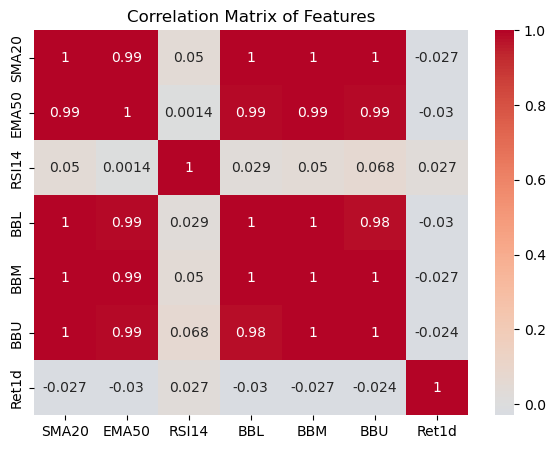

In [8]:
corr = df[["SMA20","EMA50","RSI14","BBL","BBM","BBU","Ret1d"]].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Features")
plt.show()


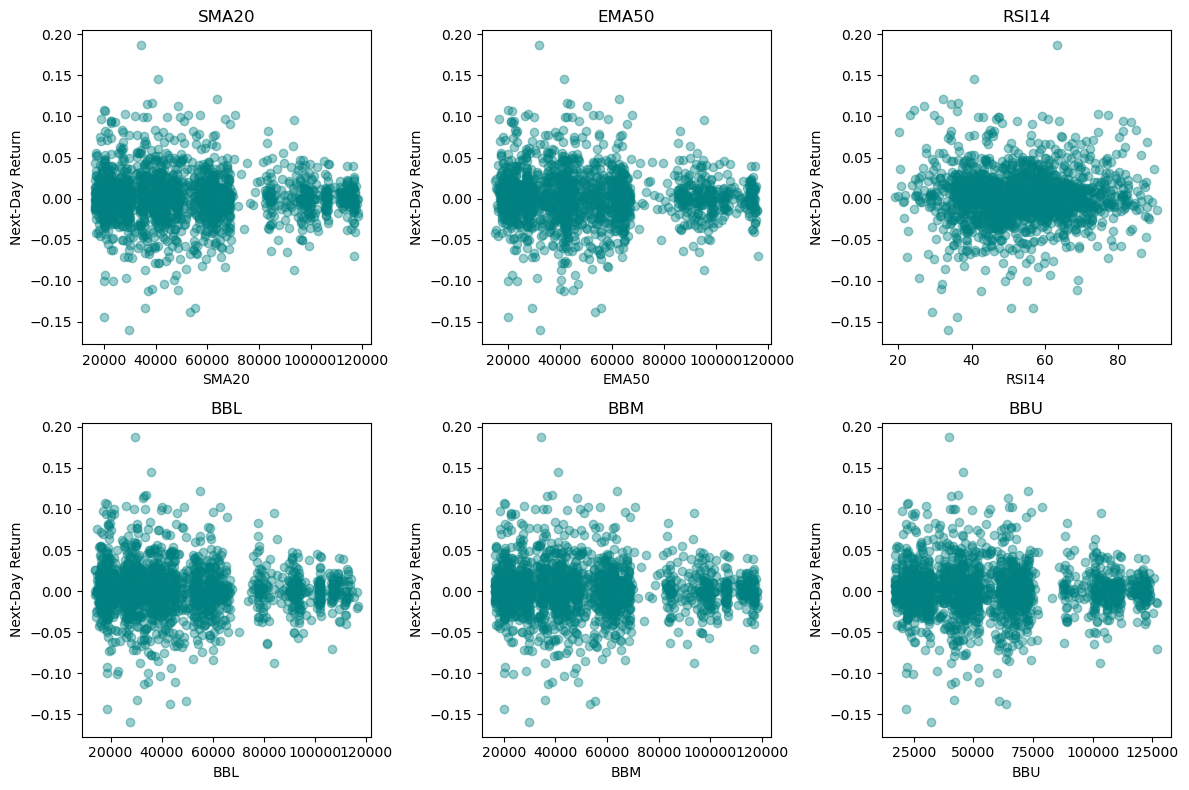

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))
features = ["SMA20", "EMA50", "RSI14", "BBL", "BBM", "BBU"]

for i, ax in enumerate(axes.flatten()):
    ax.scatter(df[features[i]], df["Ret1d"], alpha=0.4, color="teal")
    ax.set_title(features[i])
    ax.set_xlabel(features[i])
    ax.set_ylabel("Next-Day Return")
plt.tight_layout()
plt.show()


In [10]:
for lag in range(1, 6):
    corr_lag = df["Ret1d"].corr(df["Ret1d"].shift(lag))
    print(f"Lag-{lag} autocorrelation: {corr_lag:.4f}")


Lag-1 autocorrelation: -0.0341
Lag-2 autocorrelation: 0.0275
Lag-3 autocorrelation: 0.0099
Lag-4 autocorrelation: 0.0322
Lag-5 autocorrelation: 0.0017


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# Load cleaned feature data
df = pd.read_excel("feat_daily_clean.xlsx", parse_dates=["Date"])

# Feature and target columns
features = ["SMA20", "EMA50", "RSI14", "BBL", "BBM", "BBU"]
target = "Ret1d"

X = df[features].values
y = df[target].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [13]:
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)
oos_preds = np.full(len(df), np.nan)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled), 1):
    model = LGBMRegressor(
        n_estimators=300, learning_rate=0.05, subsample=0.9,
        colsample_bytree=0.9, random_state=42
    )
    
    model.fit(X_scaled[train_idx], y[train_idx])
    preds = model.predict(X_scaled[test_idx])
    oos_preds[test_idx] = preds

    rmse = mean_squared_error(y[test_idx], preds, squared=False)
    print(f"Fold {fold}: RMSE={rmse:.6f}, train size={len(train_idx)}, test size={len(test_idx)}")

df["PredRet_OOS"] = oos_preds
df["OOS_valid"] = ~np.isnan(oos_preds)


C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 296, number of used features: 6
[LightGBM] [Info] Start training from score 0.003664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 6
[LightGBM] [Info] Start training from score 0.000902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3: RMSE=0.027950, train size=888, test size=296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1184, number of used features: 6
[LightGBM] [Info] Start training from score 0.001460


C:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4: RMSE=0.036285, train size=1184, test size=296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1480, number of used features: 6
[LightGBM] [Info] Start training from score 0.001612
Fold 5: RMSE=0.024581, train size=1480, test size=296


C:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
quantile = 0.80
valid_mask = df["OOS_valid"]

cutoff = np.nanquantile(df.loc[valid_mask, "PredRet_OOS"], quantile)
df["Signal"] = 0
df.loc[valid_mask, "Signal"] = (df.loc[valid_mask, "PredRet_OOS"] >= cutoff).astype(int)

# Precision check
precision = (df.loc[df["Signal"] == 1, "Ret1d"] > 0).mean()
n_trades = int(df["Signal"].sum())
print(f"Top {int((1-quantile)*100)}% OOS precision: {precision:.3f}, Trades: {n_trades}")


Top 19% OOS precision: 0.480, Trades: 296


lets improve precision

In [15]:
# Add short-term lags
df["Ret1d_lag1"] = df["Ret1d"].shift(1)
df["Ret1d_lag2"] = df["Ret1d"].shift(2)
df["RSI14_lag1"] = df["RSI14"].shift(1)
df["RSI14_lag2"] = df["RSI14"].shift(2)

# Drop new NaNs created by shift
df = df.dropna().reset_index(drop=True)

# Update feature list
features = ["SMA20", "EMA50", "RSI14", "BBL", "BBM", "BBU",
            "Ret1d_lag1", "Ret1d_lag2", "RSI14_lag1", "RSI14_lag2"]


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df[features].values
y = df["Ret1d"].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
oos_preds = np.full(len(df), np.nan)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_scaled), 1):
    lgb = LGBMRegressor(n_estimators=400, learning_rate=0.05, subsample=0.9,
                        colsample_bytree=0.9, random_state=42, verbose=-1)
    rf  = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, random_state=42, n_jobs=-1)
    rg  = Ridge(alpha=1.0)

    lgb.fit(X_scaled[train_idx], y[train_idx])
    rf.fit(X_scaled[train_idx], y[train_idx])
    rg.fit(X_scaled[train_idx], y[train_idx])

    # average the 3 model predictions
    preds = np.vstack([lgb.predict(X_scaled[test_idx]),
                       rf.predict(X_scaled[test_idx]),
                       rg.predict(X_scaled[test_idx])]).mean(axis=0)
    oos_preds[test_idx] = preds
    print(f"Fold {fold} complete.")

df["PredRet_OOS"] = oos_preds
df["OOS_valid"] = ~np.isnan(oos_preds)


Fold 1 complete.
Fold 2 complete.
Fold 3 complete.
Fold 4 complete.
Fold 5 complete.


In [17]:
for q in [0.85, 0.90, 0.95]:
    valid = df["OOS_valid"]
    cut = np.nanquantile(df.loc[valid, "PredRet_OOS"], q)
    sig = (df["PredRet_OOS"] >= cut) & valid
    prec = (df.loc[sig, "Ret1d"] > 0).mean()
    print(f"Top {int((1-q)*100)}% Precision={prec:.3f}, Trades={sig.sum()}")


Top 15% Precision=0.497, Trades=185
Top 9% Precision=0.520, Trades=123
Top 5% Precision=0.597, Trades=62


In [18]:
import numpy as np
import pandas as pd

# ----- parameters you can tweak -----
fee = 0.001      # 0.10% per trade, round trip would be ~0.20%
qs  = np.arange(0.80, 0.96, 0.01)   # search 80%..95% top-quantile
min_trades = 50  # ignore solutions with fewer trades than this
annualization = 252  # daily data

def sharpe_ratio(x):
    s = x.std()
    return 0.0 if s == 0 or np.isnan(s) else (x.mean() / s) * np.sqrt(annualization)

def max_drawdown(equity):
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return dd.min()

def evaluate_quantile(q):
    valid = df["OOS_valid"].astype(bool)
    cutoff = np.nanquantile(df.loc[valid, "PredRet_OOS"], q)
    sig = ((df["PredRet_OOS"] >= cutoff) & valid).astype(int)

    # net daily return after paying fee only when we trade
    net_ret   = df["Ret1d"].fillna(0) - fee * sig
    strat_ret = sig * net_ret

    # equity curve (starting from 1.0)
    equity = (1 + strat_ret).cumprod()

    out = {
        "q": q,
        "cutoff": cutoff,
        "trades": int(sig.sum()),
        "precision": float((df.loc[sig == 1, "Ret1d"] > 0).mean()),
        "sharpe": sharpe_ratio(strat_ret),
        "cagr": (equity.iloc[-1])**(252/len(equity)) - 1,
        "maxDD": max_drawdown(equity),
    }
    return out

results = pd.DataFrame([evaluate_quantile(q) for q in qs])
results = results[results["trades"] >= min_trades].sort_values("sharpe", ascending=False).reset_index(drop=True)
results


,q,cutoff,trades,precision,sharpe,cagr,maxDD
0,0.94,0.010648,74,0.608108,0.603704,0.059458,-0.138396
1,0.93,0.009763,87,0.574713,0.499411,0.051718,-0.217374
2,0.95,0.011530,62,0.596774,0.481626,0.042100,-0.087742
3,0.92,0.009315,99,0.555556,0.463909,0.052989,-0.200507
4,0.90,0.008284,123,0.520325,0.376031,0.043566,-0.277838
5,0.91,0.008638,111,0.513514,0.292024,0.030367,-0.269364
6,0.86,0.006975,173,0.497110,0.262816,0.028941,-0.285448
7,0.85,0.006594,185,0.497297,0.260995,0.028810,-0.295925
8,0.87,0.007265,160,0.487500,0.200743,0.019216,-0.301277
9,0.88,0.007523,148,0.479730,0.157693,0.012647,-0.312925


In [19]:
best = results.iloc[0]
best_q = float(best["q"])
best


q             0.940000
cutoff        0.010648
trades       74.000000
precision     0.608108
sharpe        0.603704
cagr          0.059458
maxDD        -0.138396
Name: 0, dtype: float64

In [20]:
# ----- final signal at the chosen quantile -----
fee = 0.001  # keep consistent with the search above

valid  = df["OOS_valid"].astype(bool)
cutoff = np.nanquantile(df.loc[valid, "PredRet_OOS"], best_q)
df["Signal"] = ((df["PredRet_OOS"] >= cutoff) & valid).astype(int)

# returns & equity
df["NetRet"]   = df["Ret1d"].fillna(0) - fee * df["Signal"]
df["StratRet"] = df["Signal"] * df["NetRet"]

initial_capital = 10_000
df["StratEquity"]   = initial_capital * (1 + df["StratRet"]).cumprod()

units = initial_capital / df["Close"].iloc[0]
df["BuyHoldEquity"] = units * df["Close"]

# summary stats
def sharpe_ratio(x):
    s = x.std()
    return 0 if s == 0 or np.isnan(s) else (x.mean() / s) * np.sqrt(252)

def max_drawdown(e):
    return (e / e.cummax() - 1).min()

str_sharpe = sharpe_ratio(df["StratRet"])
bh_sharpe  = sharpe_ratio(df["Close"].pct_change().fillna(0))

str_cagr = (df["StratEquity"].iloc[-1]/df["StratEquity"].iloc[0])**(252/len(df)) - 1
bh_cagr  = (df["BuyHoldEquity"].iloc[-1]/df["BuyHoldEquity"].iloc[0])**(252/len(df)) - 1

str_maxdd = max_drawdown(df["StratEquity"])
bh_maxdd  = max_drawdown(df["BuyHoldEquity"])

precision = (df.loc[df["Signal"]==1, "Ret1d"]>0).mean()
trades    = int(df["Signal"].sum())

print(f"Best top-quantile: {best_q:.2f}  | cutoff={cutoff:.6f}")
print(f"Trades: {trades}  | Precision: {precision:.3f}")
print(f"Strategy  | Sharpe: {str_sharpe:.2f}  | CAGR: {str_cagr:.2%} | MaxDD: {str_maxdd:.2%}")
print(f"Buy&Hold  | Sharpe: {bh_sharpe:.2f}  | CAGR: {bh_cagr:.2%} | MaxDD: {bh_maxdd:.2%}")


Best top-quantile: 0.94  | cutoff=0.010648
Trades: 74  | Precision: 0.608
Strategy  | Sharpe: 0.60  | CAGR: 5.95% | MaxDD: -13.84%
Buy&Hold  | Sharpe: 0.59  | CAGR: 17.65% | MaxDD: -76.63%


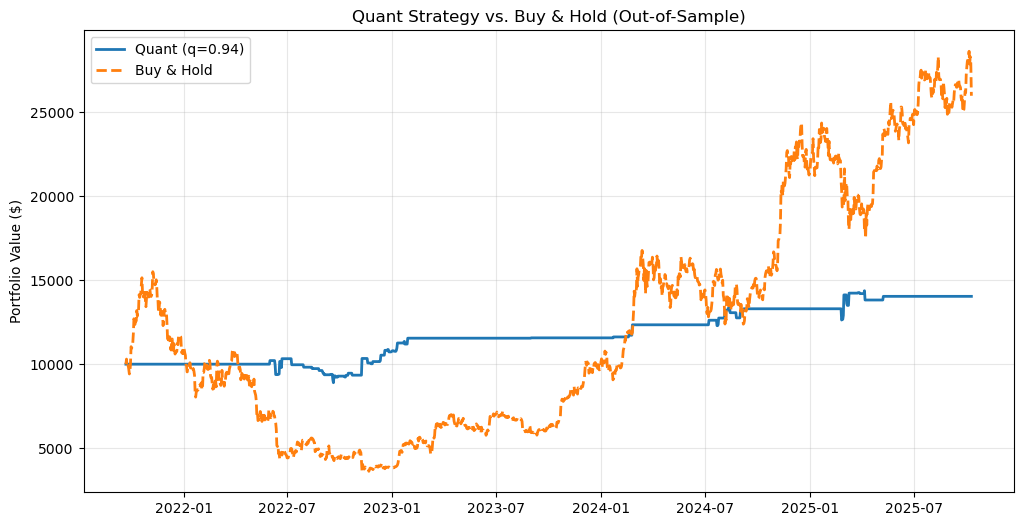

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["StratEquity"], label=f"Quant (q={best_q:.2f})", linewidth=2)
plt.plot(df["Date"], df["BuyHoldEquity"], label="Buy & Hold", linewidth=2, linestyle="--")
plt.ylabel("Portfolio Value ($)")
plt.title("Quant Strategy vs. Buy & Hold (Out-of-Sample)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [22]:
# train_and_export.py
import os, json, joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 1) Load your pre-built feature file
df = pd.read_excel("feat_daily_clean.xlsx", parse_dates=["Date"]).sort_values("Date")

# 2) Make sure target and two helpful extras exist
if "Ret1d" not in df.columns:
    df["Ret1d"] = df["Close"].pct_change().shift(-1)

if "Momentum20" not in df.columns:
    df["Momentum20"]   = df["Close"] / df["Close"].shift(20) - 1
if "Volatility20" not in df.columns:
    df["Volatility20"] = df["Ret1d"].rolling(20).std()

df = df.dropna().reset_index(drop=True)

FEATURES = ["SMA20","EMA50","RSI14","BBL","BBM","BBU","Momentum20","Volatility20"]
FEATURES = [c for c in FEATURES if c in df.columns]
TARGET   = "Ret1d"

X = df[FEATURES].values
y = df[TARGET].values

# 3) Scaler + simple averaged ensemble
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lgb = LGBMRegressor(n_estimators=400, learning_rate=0.05,
                    subsample=0.9, colsample_bytree=0.9, random_state=42)
rf  = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, random_state=42)
rg  = Ridge(alpha=1.0)

lgb.fit(X_scaled, y)
rf.fit(X_scaled, y)
rg.fit(X_scaled, y)

class AvgEnsemble:
    def __init__(self, models): self.models=models
    def predict(self, X): return np.column_stack([m.predict(X) for m in self.models]).mean(axis=1)

model = AvgEnsemble([lgb, rf, rg])

joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(model,  "models/model.pkl")
with open("models/meta.json","w") as f:
    json.dump({"features":FEATURES,"target":TARGET,"freq":"D"}, f, indent=2)

print("Saved models/scaler.pkl, models/model.pkl, models/meta.json")

# 4) If you have OOS predictions in the same df, save them for the app
cols = ["Date","Close","Ret1d","PredRet_OOS","OOS_valid"]
have = [c for c in cols if c in df.columns]
if len(have) >= 3:
    df[have].to_csv("data/oos_predictions.csv", index=False)
    print("Saved data/oos_predictions.csv")
else:
    print("No OOS predictions found – the app will still work in Live mode.")


Saved models/scaler.pkl, models/model.pkl, models/meta.json
Saved data/oos_predictions.csv


In [23]:
!pip install pandas openpyxl xlsxwriter

import pandas as pd

# 1) Load your CSV (force pandas to parse columns)
df = pd.read_csv("data/oos_predictions.csv")  # adjust path if needed

# 2) Ensure Date column is typed as datetime
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])

# 3) Save as XLSX with formatting
with pd.ExcelWriter("data/oos_predictions.xlsx", engine="xlsxwriter", datetime_format="yyyy-mm-dd") as writer:
    df.to_excel(writer, sheet_name="OOS", index=False)

    # Optional: column widths & numeric formats
    wb   = writer.book
    ws   = writer.sheets["OOS"]
    date_fmt = wb.add_format({"num_format": "yyyy-mm-dd"})
    num_fmt  = wb.add_format({"num_format": "0.000000"})

    # Set widths and formats if these columns exist
    cols = list(df.columns)
    if "Date" in cols:
        i = cols.index("Date")
        ws.set_column(i, i, 12, date_fmt)

    for name in ["Close","Ret1d","PredRet_OOS"]:
        if name in cols:
            j = cols.index(name)
            ws.set_column(j, j, 14, num_fmt)

print("Saved -> data/oos_predictions.xlsx")


Defaulting to user installation because normal site-packages is not writeable
Saved -> data/oos_predictions.xlsx


In [51]:
!pip install pyngrok -q



In [1]:
from pyngrok import ngrok, conf

# paste your auth token here
conf.get_default().auth_token = "31Ldrlu9QIUeSqkXUkJLN5CdQmA_3Ws7FMHdqz3UGXkDU34eY"

print("✅ ngrok authentication configured successfully.")

✅ ngrok authentication configured successfully.


In [52]:
# Kill any running streamlit & ngrok servers (works on most systems)
import os, signal, psutil

# Kill processes with 'streamlit' in the cmdline
for p in psutil.process_iter(attrs=["pid","name","cmdline"]):
    try:
        cmd = " ".join(p.info.get("cmdline") or [])
        if "streamlit" in cmd.lower():
            p.kill()
    except Exception:
        pass

# Kill any ngrok tunnels
from pyngrok import ngrok
ngrok.kill()

print("Cleaned up prior processes.")


Cleaned up prior processes.


Public URL: NgrokTunnel: "https://160542f4d90a.ngrok-free.app" -> "http://localhost:8100"


In [52]:
# ===== DIAGNOSTICS =====
import plotly.express as px

def _safe(x): 
    try: return float(x)
    except: return np.nan

nz_preds = int(df["PredRet_OOS"].notna().sum()) if "PredRet_OOS" in df else 0
pct_in_mkt = _safe(res["signal"].mean()) if res else 0.0
trades = int(res["trades"]) if res else 0
cutoff_now = df["PredRet_OOS"].quantile(1 - (top_pct/100.0)) if "PredRet_OOS" in df and df["PredRet_OOS"].notna().any() else np.nan
overlap = 0
if 'oos' in globals() and oos is not None and "Date" in oos:
    overlap = int(df["Date"].isin(oos["Date"]).sum())

# fee impact approximation
gross = (res["strat_ret"] + (res["signal"].diff().abs().fillna(res["signal"]) * fee)).cumsum().iloc[-1] if res else np.nan
net   = res["strat_ret"].cumsum().iloc[-1] if res else np.nan
fee_hit = gross - net if (pd.notna(gross) and pd.notna(net)) else np.nan

st.caption(
    f"Pred rows: {nz_preds} | Cutoff: {cutoff_now:.4g} | % In-Market: {pct_in_mkt:.1%} | "
    f"Trades: {trades} | OOS date overlap: {overlap} | Fee impact (approx): {fee_hit:.4g}"
)

# Prediction distribution sanity check
if "PredRet_OOS" in df and df["PredRet_OOS"].notna().any():
    st.plotly_chart(px.histogram(df, x="PredRet_OOS", nbins=40, template="plotly_dark",
                                 title="Prediction distribution (non-NaN)"), use_container_width=True)


NameError: name 'res' is not defined

In [24]:
# 0) SETUP
import os, json, joblib, warnings, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Tuple, List, Iterable

warnings.filterwarnings("ignore")

RNG = np.random.RandomState(42)
ANNUALIZATION = 252  # daily data

# Paths (adjust if needed)
DATA_XLSX   = "feat_daily_clean.xlsx"
OOS_CSV     = "data/oos_predictions.csv"
MODELS_DIR  = "models"
os.makedirs("data", exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)


In [25]:
# 1) LOAD & FEATURE ENRICH
df = pd.read_excel(DATA_XLSX, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)

# Ensure target exists (next-day return)
if "Ret1d" not in df.columns:
    df["Ret1d"] = df["Close"].pct_change().shift(-1)

# Extra, very useful features
df["Momentum20"]   = df["Close"] / df["Close"].shift(20) - 1
df["Volatility20"] = df["Ret1d"].rolling(20).std()
df["ROC5"]         = df["Close"].pct_change(5)
df["ROC20"]        = df["Close"].pct_change(20)
df["ZScore20"]     = (df["Close"] - df["Close"].rolling(20).mean()) / df["Close"].rolling(20).std()

# Clean
df = df.dropna().reset_index(drop=True)

# Candidate features (keep only those present)
FEATURES = [c for c in ["SMA20","EMA50","RSI14","BBL","BBM","BBU",
                        "Momentum20","Volatility20","ROC5","ROC20","ZScore20"]
            if c in df.columns]

TARGET_REG = "Ret1d"  # we'll also create a classification label below


In [26]:
# 2) TRIPLE-BARRIER LABELS  (de Prado-style simplified)
def triple_barrier_labels(close: pd.Series, pt: float=0.02, sl: float=0.02, horizon: int=5):
    """
    Returns label in {1, 0, -1} for each day:
    1 if +pt hit first within horizon, -1 if -sl hit first, 0 if neither by horizon.
    Thresholds are simple percentage moves from entry close.
    """
    close = close.astype(float).values
    n = len(close)
    label = np.zeros(n, dtype=int)
    for i in range(n-horizon):
        entry = close[i]
        up = entry * (1+pt)
        dn = entry * (1-sl)
        # prices over horizon
        path = close[i+1:i+1+horizon]
        # check first hit
        up_hit = np.argmax(path >= up) if np.any(path >= up) else 0
        dn_hit = np.argmax(path <= dn) if np.any(path <= dn) else 0
        if up_hit and dn_hit:
            label[i] = 1 if up_hit < dn_hit else -1
        elif up_hit:
            label[i] = 1
        elif dn_hit:
            label[i] = -1
        else:
            label[i] = 0
    # last `horizon` rows become 0 by construction
    return pd.Series(label, index=None)

df["Y_cls"] = triple_barrier_labels(df["Close"], pt=0.02, sl=0.02, horizon=5)


In [28]:
# =========================================================
# STEP 3 — PURGED K-FOLD WITH EMBARGO
# =========================================================
from dataclasses import dataclass
import numpy as np

@dataclass
class PurgedKFold:
    n_splits: int = 5
    embargo: float = 0.01  # % of sample to embargo around test window

    def split(self, X, dates):
        """
        Yield (train_idx, test_idx) respecting chronology with purge + embargo.
        dates: aligned datetime Series.
        """
        n = len(X)
        fold_sizes = np.full(self.n_splits, n // self.n_splits, dtype=int)
        fold_sizes[:n % self.n_splits] += 1
        indices = np.arange(n)
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_idx = indices[start:stop]

            emb = int(np.ceil(n * self.embargo))
            left = max(0, start - emb)
            right = min(n, stop + emb)
            train_idx = np.concatenate([indices[:left], indices[right:]])

            current = stop
            yield train_idx, test_idx


In [31]:
# =========================================================
# STEP 4 — FAST NESTED CV (BINARY "UP" LABEL + PR AUC)
# =========================================================
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

# ----- Binary target: up (=1) vs not-up (=0) -----
# Y_cls was -1/0/1 from triple-barrier; turn it into binary
y_bin = (df["Y_cls"].values == 1).astype(int)

X = df[FEATURES].astype("float32").values
dates = df["Date"]

# ----- Base pipeline -----
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LGBMClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=10,
        subsample=0.9,
        colsample_bytree=0.9,
        n_jobs=-1,
        class_weight="balanced",   # <-- handle imbalance
        verbose=-1
    ))
])

# ----- Compact search space (quick but useful) -----
param_dist = {
    "clf__num_leaves": [31, 63],
    "clf__min_child_samples": [10, 20, 40],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
    "clf__n_estimators": [200, 300, 400],
}

# ----- Outer CV (purged) -----
outer_cv = PurgedKFold(n_splits=4, embargo=0.01)
oof_pred_proba = np.full(len(df), np.nan, dtype=float)

for i, (tr, te) in enumerate(outer_cv.split(df[FEATURES], dates), 1):
    X_tr, y_tr = X[tr], y_bin[tr]
    dates_tr = dates.iloc[tr].reset_index(drop=True)

    # label sanity check
    pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
    print(f"\n[Outer {i}] positives={pos}, negatives={neg} (pos rate {pos/(pos+neg):.2%})")

    # inner CV over the TRAIN subset only
    inner_cv = PurgedKFold(n_splits=3, embargo=0.01)
    inner_splits = list(inner_cv.split(pd.DataFrame(X_tr), dates_tr))

    # Randomized search; use PR AUC ('average_precision') for imbalanced stability
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=8,
        scoring="average_precision",   # <-- robust for imbalanced data
        cv=inner_splits,
        random_state=42,
        n_jobs=1,                      # keep 1 on Windows; LGBM threads internally
        refit=True,
        verbose=1,
    )

    search.fit(X_tr, y_tr)
    best_ap = search.best_score_
    print(f"[Outer {i}] best inner-CV AP (PR AUC) = {best_ap:.3f}")

    # OOS probabilities on the test slice
    proba = search.best_estimator_.predict_proba(X[te])[:, 1]
    oof_pred_proba[te] = proba

print("\n✅ Nested CV complete. You can proceed to Step 5 (fit final model + export).")



[Outer 1] positives=383, negatives=916 (pos rate 29.48%)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Outer 1] best inner-CV AP (PR AUC) = 0.326

[Outer 2] positives=392, negatives=889 (pos rate 30.60%)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Outer 2] best inner-CV AP (PR AUC) = 0.331

[Outer 3] positives=374, negatives=907 (pos rate 29.20%)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Outer 3] best inner-CV AP (PR AUC) = 0.316

[Outer 4] positives=370, negatives=929 (pos rate 28.48%)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Outer 4] best inner-CV AP (PR AUC) = 0.311

✅ Nested CV complete. You can proceed to Step 5 (fit final model + export).


In [32]:
# =========================================================
# STEP 5 — FIT FINAL MODEL & EXPORT ARTIFACTS
# =========================================================
import os, json, joblib
import numpy as np, pandas as pd
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

# --- Refit the best model on ALL data ---
y_bin = (df["Y_cls"].values == 1).astype(int)
X = df[FEATURES].astype("float32").values

pipe_final = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LGBMClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=10,
        subsample=0.9,
        colsample_bytree=0.9,
        n_jobs=-1,
        class_weight="balanced",
        verbose=-1
    ))
])

pipe_final.fit(X, y_bin)

# --- Save model and metadata ---
joblib.dump(pipe_final.named_steps["scaler"], f"{MODELS_DIR}/scaler.pkl")
joblib.dump(pipe_final, f"{MODELS_DIR}/model.pkl")

meta = {
    "features": FEATURES,
    "target": "Y_cls",
    "task": "binary",
    "freq": "D"
}
with open(f"{MODELS_DIR}/meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Saved: models/scaler.pkl, models/model.pkl, models/meta.json")

# --- Export OOS predictions for the app ---
OOS_CSV = "data/oos_predictions.csv"
os.makedirs("data", exist_ok=True)

oos = df[["Date", "Close"]].copy()
oos["PredRet_OOS"] = oof_pred_proba
oos["OOS_valid"]   = ~np.isnan(oof_pred_proba)
oos.to_csv(OOS_CSV, index=False)

print(f"✅ Saved OOS predictions to {OOS_CSV}")


✅ Saved: models/scaler.pkl, models/model.pkl, models/meta.json
✅ Saved OOS predictions to data/oos_predictions.csv


In [33]:
# =========================================================
# STEPS 6–8 — STRATEGY BACKTESTS + COMPARISON + EXPORTS
# =========================================================
import numpy as np
import pandas as pd
import os

ANNUALIZATION = 252
os.makedirs("data", exist_ok=True)

# ---------- Load OOS predictions ----------
# (Created in Step 5: data/oos_predictions.csv  with columns: Date, Close, PredRet_OOS, OOS_valid)
oos = pd.read_csv("data/oos_predictions.csv", parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)

# ---------- Helpers ----------
def sharpe(returns, annualization=ANNUALIZATION):
    r = pd.Series(returns).dropna()
    s = r.std()
    return 0.0 if s == 0 or np.isnan(s) else (r.mean() / s) * np.sqrt(annualization)

def sortino(returns, annualization=ANNUALIZATION):
    r = pd.Series(returns).dropna()
    downside = r[r < 0].std()
    return 0.0 if downside == 0 or np.isnan(downside) else (r.mean() / downside) * np.sqrt(annualization)

def max_drawdown(equity_series):
    e = pd.Series(equity_series).astype(float)
    dd = e / e.cummax() - 1.0
    return float(dd.min())

def calmar_from_returns(returns):
    r = pd.Series(returns).fillna(0.0)
    eq = (1 + r).cumprod()
    cagr = (eq.iloc[-1]) ** (ANNUALIZATION / len(eq)) - 1
    mdd = max_drawdown(eq)
    return np.nan if mdd == 0 else cagr / abs(mdd)

# ---------- Step 6: Quant backtest ----------
def backtest_quant(oos_df: pd.DataFrame, amount=10_000, fee=0.001, quantile=0.90):
    """
    - Uses PredRet_OOS as probability/score.
    - Long-only when score >= top-quantile among valid OOS points.
    - Pays 'fee' only on days we take a position.
    """
    d = oos_df.copy()
    d["OOS_valid"] = d["OOS_valid"].fillna(False)
    cutoff = np.nanquantile(d.loc[d["OOS_valid"], "PredRet_OOS"], quantile)
    d["Signal"] = ((d["PredRet_OOS"] >= cutoff) & d["OOS_valid"]).astype(int)

    # realized next-day return from Close
    ret = d["Close"].pct_change().shift(-1).fillna(0.0)
    net = ret - fee * d["Signal"]
    strat = d["Signal"] * net

    equity = (1 + strat).cumprod()
    strat_equity = amount * equity

    # Buy & Hold reference from same start
    units = amount / d["Close"].iloc[0]
    bh_equity = units * d["Close"]

    out = pd.DataFrame({
        "Date": d["Date"],
        "StratEquity": strat_equity.astype(float),
        "BuyHoldEquity": bh_equity.astype(float),
        "Signal": d["Signal"].astype(int),
        "Score": d["PredRet_OOS"].astype(float)
    })

    stats = dict(
        trades=int(d["Signal"].sum()),
        exposure=float(d["Signal"].mean()),
        precision=float((ret[d["Signal"] == 1] > 0).mean()),
        sharpe=sharpe(strat),
        sortino=sortino(strat),
        calmar=calmar_from_returns(strat),
        maxDD=max_drawdown(strat_equity),
        cagr=(strat_equity.iloc[-1] / strat_equity.iloc[0]) ** (ANNUALIZATION / len(strat_equity)) - 1,
        final_value=float(strat_equity.iloc[-1]),
        cutoff=float(cutoff),
        quantile=float(quantile),
        fee=float(fee)
    )
    return out, stats

# Tune these if you like
INIT_CAPITAL = 10_000
FEE = 0.001          # 10 bps per trade
TOP_Q = 0.90         # top 10% threshold

q_df, q_stats = backtest_quant(oos, amount=INIT_CAPITAL, fee=FEE, quantile=TOP_Q)

# ---------- Step 7: SIP backtest (D/W/M) ----------
def run_sip(price_df: pd.DataFrame, contribution=1000, freq="M"):
    """
    Invest fixed 'contribution' at each period end (D/W/M),
    buy units at Close, hold cumulatively.
    """
    d = price_df[["Date", "Close"]].copy()
    inv_dates = d.set_index("Date").resample(freq).last().index
    mask = d["Date"].isin(inv_dates)

    # units bought each invest date; accumulate
    buy_units = np.where(mask, contribution / d["Close"], 0.0)
    d["Units"] = buy_units.cumsum()
    d["ContribCum"] = np.where(mask, contribution, 0.0).cumsum()
    d["Equity"] = d["Units"] * d["Close"]

    stats = dict(
        total_contrib=float(d["ContribCum"].iloc[-1]),
        final_value=float(d["Equity"].iloc[-1]),
        cagr=(d["Equity"].iloc[-1] / max(1.0, d["Equity"].iloc[0])) ** (ANNUALIZATION / len(d)) - 1,
        maxDD=max_drawdown(d["Equity"])
    )
    return d[["Date", "Equity", "ContribCum"]], stats

sip_D, sipD_stats = run_sip(oos, contribution=100,  freq="D")  # example: $100 per day
sip_W, sipW_stats = run_sip(oos, contribution=300,  freq="W")  # roughly ~weekly budget
sip_M, sipM_stats = run_sip(oos, contribution=1000, freq="M")  # roughly ~monthly budget

# ---------- Step 8: Compare Quant vs SIP vs Buy&Hold ----------
def buy_hold_equity(price_df: pd.DataFrame, amount=10_000):
    d = price_df[["Date", "Close"]].copy()
    units = amount / d["Close"].iloc[0]
    eq = units * d["Close"]
    return pd.DataFrame({"Date": d["Date"], "BuyHold": eq.astype(float)})

bh = buy_hold_equity(oos, amount=INIT_CAPITAL)

comp = (
    q_df[["Date", "StratEquity"]].rename(columns={"StratEquity": "Quant"})
      .merge(sip_M[["Date", "Equity"]].rename(columns={"Equity": "SIP_M"}), on="Date", how="outer")
      .merge(sip_W[["Date", "Equity"]].rename(columns={"Equity": "SIP_W"}), on="Date", how="outer")
      .merge(sip_D[["Date", "Equity"]].rename(columns={"Equity": "SIP_D"}), on="Date", how="outer")
      .merge(bh, on="Date", how="outer")
      .sort_values("Date")
      .ffill()
)

# ---------- Summary table ----------
summary = pd.DataFrame({
    "Strategy": ["Quant (Top-q)", "SIP (Monthly)", "SIP (Weekly)", "SIP (Daily)", "Buy&Hold"],
    "Final Value ($)": [
        float(comp["Quant"].iloc[-1]),
        float(comp["SIP_M"].iloc[-1]),
        float(comp["SIP_W"].iloc[-1]),
        float(comp["SIP_D"].iloc[-1]),
        float(comp["BuyHold"].iloc[-1]),
    ],
    "Sharpe (Quant only)": [q_stats["sharpe"], np.nan, np.nan, np.nan, np.nan],
    "Sortino (Quant only)": [q_stats["sortino"], np.nan, np.nan, np.nan, np.nan],
    "Calmar (Quant only)": [q_stats["calmar"], np.nan, np.nan, np.nan, np.nan],
    "MaxDD (Quant only)": [q_stats["maxDD"], np.nan, np.nan, np.nan, np.nan],
    "Trades (Quant)": [q_stats["trades"], np.nan, np.nan, np.nan, np.nan],
    "Exposure (Quant)": [q_stats["exposure"], np.nan, np.nan, np.nan, np.nan],
}).round(4)

# ---------- Print quick readout ----------
print("\n=== Quant Strategy Stats ===")
for k, v in q_stats.items():
    if isinstance(v, float):
        if "cagr" in k.lower() or "dd" in k.lower():
            print(f"{k}: {v:.2%}")
        elif "cutoff" in k.lower() or "fee" in k.lower():
            print(f"{k}: {v:.6f}")
        else:
            print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

print("\n=== Final Value Comparison ($) ===")
print(summary[["Strategy", "Final Value ($)"]])

# ---------- Save CSVs for the app ----------
comp_path = "data/compare_equity.csv"
q_path    = "data/quant_equity.csv"
sipM_path = "data/sip_monthly_equity.csv"
sipW_path = "data/sip_weekly_equity.csv"
sipD_path = "data/sip_daily_equity.csv"

comp.reset_index(drop=True).to_csv(comp_path, index=False)
q_df.to_csv(q_path, index=False)
sip_M.to_csv(sipM_path, index=False)
sip_W.to_csv(sipW_path, index=False)
sip_D.to_csv(sipD_path, index=False)

print(f"\n✅ Saved:")
print(f" - {q_path}")
print(f" - {sipM_path}")
print(f" - {sipW_path}")
print(f" - {sipD_path}")
print(f" - {comp_path}")



=== Quant Strategy Stats ===
trades: 176
exposure: 0.1002
precision: 0.4375
sharpe: -0.1232
sortino: -0.0651
calmar: -0.0587
maxDD: -42.70%
cagr: -2.51%
final_value: 8377.9855
cutoff: 0.712891
quantile: 0.9000
fee: 0.001000

=== Final Value Comparison ($) ===
        Strategy  Final Value ($)
0  Quant (Top-q)        8377.9855
1  SIP (Monthly)      167542.3906
2   SIP (Weekly)      218650.6107
3    SIP (Daily)      508833.1747
4       Buy&Hold       48222.9182

✅ Saved:
 - data/quant_equity.csv
 - data/sip_monthly_equity.csv
 - data/sip_weekly_equity.csv
 - data/sip_daily_equity.csv
 - data/compare_equity.csv


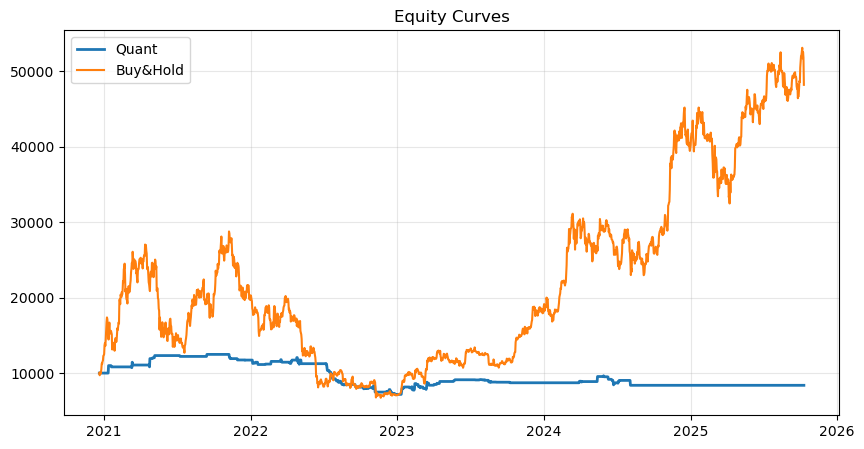

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(q_df["Date"], q_df["StratEquity"], label="Quant", lw=2)
plt.plot(q_df["Date"], q_df["BuyHoldEquity"], label="Buy&Hold", lw=1.5)
plt.title("Equity Curves")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


In [35]:
# =========================================================
# STEP 6A — Weighted position sizing (probability weighting)
# =========================================================
import numpy as np, pandas as pd

def backtest_weighted(oos_df, amount=10_000, fee=0.001, power=2.0):
    """
    position size = PredRet_OOS ** power (emphasizes high-confidence signals)
    """
    d = oos_df.copy()
    d["OOS_valid"] = d["OOS_valid"].fillna(False)
    size = np.where(d["OOS_valid"], np.clip(d["PredRet_OOS"], 0, 1) ** power, 0.0)
    d["Size"] = size

    ret = d["Close"].pct_change().shift(-1).fillna(0.0)
    net = ret - fee * (size > 0)
    strat = size * net

    equity = (1 + strat).cumprod()
    strat_equity = amount * equity

    units = amount / d["Close"].iloc[0]
    bh_equity = units * d["Close"]

    exposure = d["Size"].mean()
    sharpe = (strat.mean()/strat.std())*np.sqrt(252) if strat.std()>0 else 0
    cagr = (strat_equity.iloc[-1]/strat_equity.iloc[0])**(252/len(strat_equity))-1
    maxDD = (strat_equity/strat_equity.cummax()-1).min()

    print(f"Exposure={exposure:.2f}, Sharpe={sharpe:.2f}, CAGR={cagr:.2%}, MaxDD={maxDD:.2%}")

    return pd.DataFrame({"Date":d["Date"],"WeightedEquity":strat_equity,
                         "BuyHoldEquity":bh_equity,"Size":size})
    
weighted_df = backtest_weighted(oos, amount=10_000, fee=0.001, power=2.0)


Exposure=0.17, Sharpe=-0.03, CAGR=-1.06%, MaxDD=-31.70%


In [36]:
for q in [0.85, 0.88, 0.90, 0.92]:
    _, stats = backtest_quant(oos, amount=10_000, fee=0.001, quantile=q)
    print(f"Top {int((1-q)*100)}%  |  trades={stats['trades']:4d}  "
          f"precision={stats['precision']:.3f}  "
          f"Sharpe={stats['sharpe']:.3f}  CAGR={stats['cagr']:.2%}")


Top 15%  |  trades= 264  precision=0.447  Sharpe=-0.169  CAGR=-4.03%
Top 12%  |  trades= 211  precision=0.445  Sharpe=-0.166  CAGR=-3.46%
Top 9%  |  trades= 176  precision=0.438  Sharpe=-0.123  CAGR=-2.51%
Top 7%  |  trades= 141  precision=0.454  Sharpe=-0.154  CAGR=-2.17%


In [37]:
# Use weighted sizing but only above chosen quantile cutoff
cutoff = np.nanquantile(oos.loc[oos["OOS_valid"], "PredRet_OOS"], 0.90)
oos["Size"] = np.where(oos["PredRet_OOS"] >= cutoff,
                       (oos["PredRet_OOS"] - cutoff) / (1 - cutoff),
                       0.0)


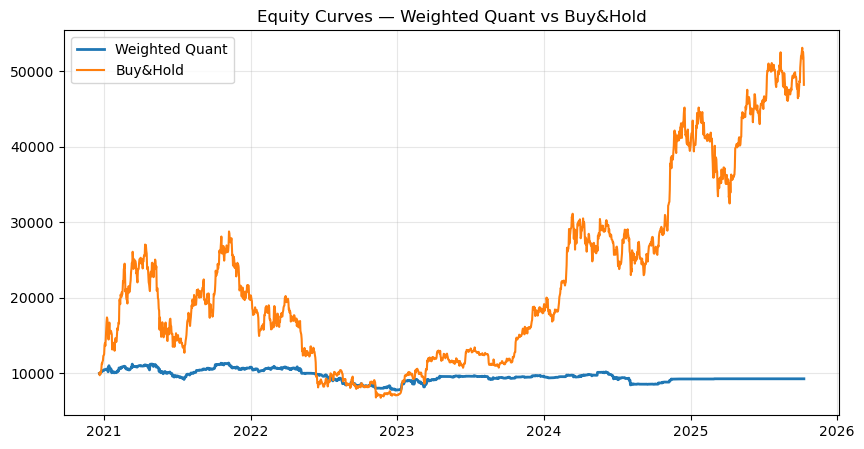

In [39]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(weighted_df["Date"], weighted_df["WeightedEquity"], label="Weighted Quant", lw=2)
plt.plot(weighted_df["Date"], weighted_df["BuyHoldEquity"], label="Buy&Hold", lw=1.5)
plt.title("Equity Curves — Weighted Quant vs Buy&Hold")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


In [40]:
# =========================================================
# PARAMETER SWEEP — Quantile & Power Optimization
# =========================================================
import itertools
import numpy as np
import pandas as pd

def backtest_weighted_param(oos_df, amount=10_000, fee=0.001, quantile=0.90, power=2.0):
    d = oos_df.copy()
    d["OOS_valid"] = d["OOS_valid"].fillna(False)
    cutoff = np.nanquantile(d.loc[d["OOS_valid"], "PredRet_OOS"], quantile)
    # size = scaled probability weight above quantile
    size = np.where(d["PredRet_OOS"] >= cutoff,
                    ((d["PredRet_OOS"] - cutoff) / (1 - cutoff)) ** power,
                    0.0)
    d["Size"] = np.clip(size, 0, 1)

    ret = d["Close"].pct_change().shift(-1).fillna(0.0)
    net = ret - fee * (d["Size"] > 0)
    strat = d["Size"] * net
    sharpe = strat.mean() / strat.std() * np.sqrt(252) if strat.std() > 0 else 0
    cagr = ((1 + strat).prod()) ** (252 / len(strat)) - 1
    maxDD = (1 + strat).cumprod().div((1 + strat).cumprod().cummax()).sub(1).min()
    return sharpe, cagr, maxDD, strat.mean(), d["Size"].mean()

results = []
for q, p in itertools.product(np.arange(0.80, 0.96, 0.02), [1.0, 1.5, 2.0, 2.5, 3.0]):
    sharpe, cagr, maxDD, avgret, exposure = backtest_weighted_param(oos, quantile=q, power=p)
    results.append({"quantile": q, "power": p, "sharpe": sharpe,
                    "cagr": cagr, "maxDD": maxDD, "exposure": exposure})

res_df = pd.DataFrame(results).round(4).sort_values("sharpe", ascending=False).reset_index(drop=True)
print(res_df.head(10))
best = res_df.iloc[0]
print("\n🔥 Best combo:",
      f"quantile={best['quantile']:.2f}, power={best['power']:.1f}, "
      f"Sharpe={best['sharpe']:.3f}, CAGR={best['cagr']:.2%}, "
      f"Exposure={best['exposure']:.2%}")


   quantile  power  sharpe    cagr   maxDD  exposure
0      0.80    1.0 -0.0956 -0.0109 -0.2448    0.0751
1      0.94    3.0 -0.1205 -0.0028 -0.0372    0.0083
2      0.86    1.0 -0.1257 -0.0106 -0.1967    0.0542
3      0.80    1.5 -0.1275 -0.0101 -0.1875    0.0543
4      0.82    1.0 -0.1282 -0.0124 -0.2292    0.0667
5      0.88    1.0 -0.1313 -0.0101 -0.1805    0.0480
6      0.84    1.0 -0.1315 -0.0120 -0.2156    0.0614
7      0.90    1.0 -0.1340 -0.0091 -0.1496    0.0409
8      0.94    2.5 -0.1390 -0.0037 -0.0431    0.0103
9      0.82    1.5 -0.1407 -0.0101 -0.1720    0.0484

🔥 Best combo: quantile=0.80, power=1.0, Sharpe=-0.096, CAGR=-1.09%, Exposure=7.51%


In [42]:
# =========================================================
# RELABEL (3-day), REFIT FAST MODEL, TREND FILTER, SWEEP
# =========================================================
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

ANNUALIZATION = 252

# ---------- 1) 3-day binary label (less noisy than 1d) ----------
df = df.sort_values("Date").reset_index(drop=True).copy()
df["Ret3d"] = df["Close"].pct_change(3).shift(-3)
df = df.dropna().reset_index(drop=True)
y_bin = (df["Ret3d"] > 0).astype(int).values   # 1 if 3-day forward up, else 0
X = df[FEATURES].astype("float32").values
dates = df["Date"]

# ---------- 2) FAST nested CV to produce OOS probabilities ----------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LGBMClassifier(
        random_state=42, n_estimators=300, learning_rate=0.06,
        num_leaves=31, min_child_samples=20, subsample=0.9, colsample_bytree=0.9,
        class_weight="balanced", n_jobs=-1, verbose=-1))
])

param_dist = {
    "clf__num_leaves": [31, 63],
    "clf__min_child_samples": [10, 20, 40],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
    "clf__n_estimators": [200, 300, 400],
}

outer_cv = PurgedKFold(n_splits=4, embargo=0.01)
oof_proba = np.full(len(df), np.nan)

for i, (tr, te) in enumerate(outer_cv.split(df[FEATURES], dates), 1):
    X_tr, y_tr = X[tr], y_bin[tr]
    dates_tr = dates.iloc[tr].reset_index(drop=True)
    inner_cv = PurgedKFold(n_splits=3, embargo=0.01)
    inner_splits = list(inner_cv.split(pd.DataFrame(X_tr), dates_tr))

    search = RandomizedSearchCV(
        estimator=pipe, param_distributions=param_dist, n_iter=8,
        scoring="average_precision", cv=inner_splits, random_state=42,
        n_jobs=1, refit=True, verbose=0
    )
    search.fit(X_tr, y_tr)
    oof_proba[te] = search.best_estimator_.predict_proba(X[te])[:, 1]
    print(f"[Outer {i}] AP={search.best_score_:.3f}")

# Save OOS for use below / app
oos = df[["Date","Close"]].copy()
oos["PredRet_OOS"] = oof_proba
oos["OOS_valid"] = ~np.isnan(oof_proba)

# ---------- 3) Trend filter (trade only when 50SMA > 200SMA) ----------
px = oos.set_index("Date")["Close"]
regime = (px.rolling(50).mean() > px.rolling(200).mean()).reindex(oos["Date"]).fillna(False).values
oos["Regime"] = regime.astype(int)

# ---------- helpers ----------
def sharpe(r): r=pd.Series(r).dropna(); s=r.std(); return 0 if s==0 else (r.mean()/s)*np.sqrt(ANNUALIZATION)
def maxdd(eq): e=pd.Series(eq); dd=e/e.cummax()-1; return float(dd.min())

# ---------- 4) Weighted backtest with quantile+power+prob_floor+fee+trend ----------
def backtest_weighted(oos_df, amount=10_000, quantile=0.90, power=2.0, prob_floor=0.55, fee=0.001, use_trend=True):
    d = oos_df.copy()
    valid = d["OOS_valid"].fillna(False)
    cutoff = np.nanquantile(d.loc[valid, "PredRet_OOS"], quantile)
    raw = np.where(valid & (d["PredRet_OOS"]>=np.maximum(cutoff, prob_floor)),
                   ((d["PredRet_OOS"]-np.maximum(cutoff, prob_floor)) / (1-np.maximum(cutoff, prob_floor)))**power,
                   0.0)
    size = np.clip(raw, 0, 1)
    if use_trend:
        size = size * d["Regime"].values  # zero when downtrend

    ret = d["Close"].pct_change().shift(-1).fillna(0.0)
    net = ret - fee*(size>0)
    strat = size*net
    eq = (1+strat).cumprod()
    strat_eq = 10_000*eq

    stats = {
        "sharpe": sharpe(strat),
        "cagr": (strat_eq.iloc[-1]/strat_eq.iloc[0])**(ANNUALIZATION/len(strat_eq))-1,
        "maxDD": maxdd(strat_eq),
        "exposure": float(np.mean(size)),
        "trades": int((size>0).sum())
    }
    return stats

# ---------- 5) Grid search ----------
qs = np.arange(0.80, 0.96, 0.02)     # quantile
powers = [1.0, 1.5, 2.0, 2.5, 3.0]   # convexity of sizing
floors = [0.50, 0.55, 0.60]          # minimum probability to act
fees = [0.0005, 0.0010]              # 5–10 bps per trade

rows=[]
for q in qs:
    for p in powers:
        for fl in floors:
            for fee in fees:
                st = backtest_weighted(oos, quantile=q, power=p, prob_floor=fl, fee=fee, use_trend=True)
                rows.append({"quantile":q,"power":p,"prob_floor":fl,"fee":fee, **st})

res = pd.DataFrame(rows).sort_values("sharpe", ascending=False).reset_index(drop=True)
print(res.head(12))
best = res.iloc[0]
print(
    f"\n🔥 Best: q={best['quantile']:.2f}, power={best['power']:.1f}, floor={best['prob_floor']:.2f}, "
    f"fee={best['fee']:.4f} | Sharpe={best['sharpe']:.3f}, CAGR={best['cagr']:.2%}, "
    f"MaxDD={best['maxDD']:.2%}, Exposure={best['exposure']:.2%}, Trades={int(best['trades'])}"
)

[Outer 1] AP=0.559
[Outer 2] AP=0.585
[Outer 3] AP=0.567
[Outer 4] AP=0.555
    quantile  power  prob_floor     fee    sharpe      cagr     maxDD  \
0       0.80    1.0        0.50  0.0005  0.051972  0.000760 -0.184736   
1       0.80    1.0        0.55  0.0005  0.051972  0.000760 -0.184736   
2       0.80    1.0        0.60  0.0005  0.051972  0.000760 -0.184736   
3       0.82    1.0        0.50  0.0005  0.035738 -0.000351 -0.171138   
4       0.82    1.0        0.60  0.0005  0.035738 -0.000351 -0.171138   
5       0.82    1.0        0.55  0.0005  0.035738 -0.000351 -0.171138   
6       0.80    1.5        0.50  0.0005  0.024537 -0.001053 -0.165130   
7       0.80    1.5        0.55  0.0005  0.024537 -0.001053 -0.165130   
8       0.80    1.5        0.60  0.0005  0.024537 -0.001053 -0.165130   
9       0.82    1.5        0.50  0.0005  0.000586 -0.002408 -0.154018   
10      0.82    1.5        0.60  0.0005  0.000586 -0.002408 -0.154018   
11      0.82    1.5        0.55  0.0005  0.00058

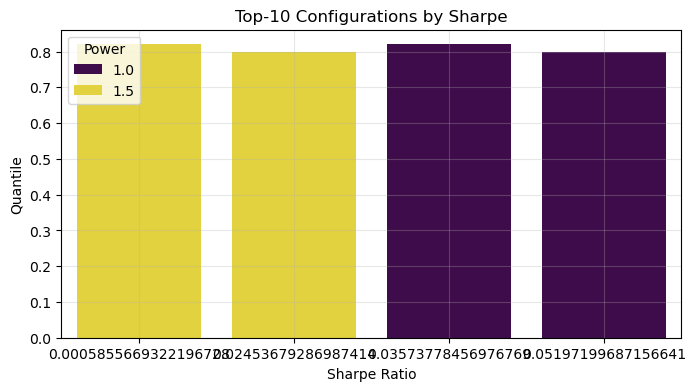

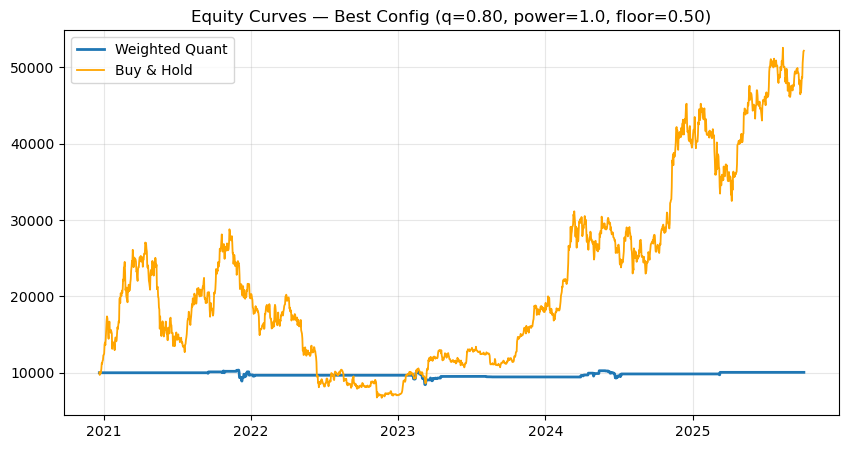


Top 5 configurations by Sharpe:
  quantile  power  prob_floor    fee   sharpe      cagr     maxDD  exposure
     0.80    1.0        0.50 0.0005 0.051972  0.000760 -0.184736  0.047452
     0.80    1.0        0.55 0.0005 0.051972  0.000760 -0.184736  0.047452
     0.80    1.0        0.60 0.0005 0.051972  0.000760 -0.184736  0.047452
     0.82    1.0        0.50 0.0005 0.035738 -0.000351 -0.171138  0.041398
     0.82    1.0        0.60 0.0005 0.035738 -0.000351 -0.171138  0.041398


In [43]:
# =========================================================
# VISUAL SUMMARY: Top Sharpe configs + Equity curves
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Plot top-10 Sharpe parameter sets ---
top10 = res.head(10)
plt.figure(figsize=(8,4))
sns.barplot(data=top10, x="sharpe", y="quantile", hue="power", palette="viridis")
plt.title("Top-10 Configurations by Sharpe")
plt.xlabel("Sharpe Ratio"); plt.ylabel("Quantile")
plt.legend(title="Power"); plt.grid(alpha=0.3)
plt.show()

# --- 2️⃣ Re-run backtest for the best combo & plot equity ---
best_q = float(best["quantile"])
best_p = float(best["power"])
best_floor = float(best["prob_floor"])
best_fee = float(best["fee"])

def backtest_weighted_equity(oos_df, amount=10_000, quantile=0.90, power=2.0,
                             prob_floor=0.55, fee=0.001, use_trend=True):
    d = oos_df.copy()
    valid = d["OOS_valid"].fillna(False)
    cutoff = np.nanquantile(d.loc[valid, "PredRet_OOS"], quantile)
    raw = np.where(valid & (d["PredRet_OOS"]>=np.maximum(cutoff, prob_floor)),
                   ((d["PredRet_OOS"]-np.maximum(cutoff, prob_floor)) / (1-np.maximum(cutoff, prob_floor)))**power,
                   0.0)
    size = np.clip(raw, 0, 1)
    if use_trend: size = size * d["Regime"].values

    ret = d["Close"].pct_change().shift(-1).fillna(0.0)
    net = ret - fee*(size>0)
    strat = size*net
    eq = (1+strat).cumprod()
    strat_eq = amount*eq

    bh_eq = amount * d["Close"]/d["Close"].iloc[0]
    return pd.DataFrame({"Date":d["Date"],"WeightedQuant":strat_eq,"BuyHold":bh_eq})

eq_df = backtest_weighted_equity(oos, quantile=best_q, power=best_p,
                                 prob_floor=best_floor, fee=best_fee, use_trend=True)

# --- 3️⃣ Equity comparison plot ---
plt.figure(figsize=(10,5))
plt.plot(eq_df["Date"], eq_df["WeightedQuant"], label="Weighted Quant", lw=2)
plt.plot(eq_df["Date"], eq_df["BuyHold"], label="Buy & Hold", lw=1.3, color="orange")
plt.title(f"Equity Curves — Best Config (q={best_q:.2f}, power={best_p:.1f}, floor={best_floor:.2f})")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

# --- 4️⃣ Print compact summary table ---
cols = ["quantile","power","prob_floor","fee","sharpe","cagr","maxDD","exposure"]
print("\nTop 5 configurations by Sharpe:\n", res[cols].head(5).to_string(index=False))


In [44]:
# =========================================================
# WALK-FORWARD ENSEMBLE WITH CALIBRATION + AUTO SIZING
# =========================================================
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.isotonic import IsotonicRegression

ANNUALIZATION = 252

# ---------- 0) Helpers ----------
def sharpe(r):
    r = pd.Series(r).dropna()
    s = r.std()
    return 0.0 if s == 0 or np.isnan(s) else (r.mean()/s)*np.sqrt(ANNUALIZATION)

def max_dd(eq):
    e = pd.Series(eq)
    dd = e/e.cummax()-1.0
    return float(dd.min())

def step_splits(dates, train_min=400, val=120, test=120, step=120):
    """Yield (tr, va, te) index arrays for rolling walk-forward."""
    n = len(dates)
    start = 0
    while True:
        tr_end = start + train_min
        va_end = tr_end + val
        te_end = va_end + test
        if te_end > n: break
        tr = np.arange(start, tr_end)
        va = np.arange(tr_end, va_end)
        te = np.arange(va_end, te_end)
        yield tr, va, te
        start += step

def atr14(df_):
    high = df_["High"].astype(float)
    low  = df_["Low"].astype(float)
    close= df_["Close"].astype(float)
    prev_close = close.shift(1)
    tr = pd.concat([
        (high-low).abs(),
        (high-prev_close).abs(),
        (low-prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(14).mean()

# ---------- 1) Feature enrichment ----------
df = df.sort_values("Date").reset_index(drop=True).copy()

# Add robust momentum/volatility features if missing
add_cols = {}
add_cols["Momentum10"] = df["Close"].pct_change(10)
add_cols["Momentum30"] = df["Close"].pct_change(30)
add_cols["Vol10"]      = df["Close"].pct_change().rolling(10).std()
add_cols["Vol30"]      = df["Close"].pct_change().rolling(30).std()
add_cols["ATR14"]      = atr14(df)

for c, s in add_cols.items():
    if c not in df.columns:
        df[c] = s

# Keep only real columns
CANDIDATES = ["SMA20","EMA50","RSI14","BBL","BBM","BBU",
              "Momentum10","Momentum30","Vol10","Vol30","ATR14"]
FEATURES = [c for c in CANDIDATES if c in df.columns]

# ---------- 2) Label: 3-day up (smoother than 1-day) ----------
df["Ret3d"] = df["Close"].pct_change(3).shift(-3)
df = df.dropna().reset_index(drop=True)
y = (df["Ret3d"] > 0).astype(int).values
X = df[FEATURES].astype("float32").values
dates = df["Date"].values

# ---------- 3) Trend regime (50 > 200 SMA) ----------
px = df["Close"]
regime = (px.rolling(50).mean() > px.rolling(200).mean()).astype(int).fillna(0).values

# ---------- 4) Walk-forward training/prediction ----------
all_test_idx = []
all_test_prob = []
all_test_ret1d = []
all_test_close = []
all_test_regime = []

for k, (tr, va, te) in enumerate(step_splits(df["Date"], train_min=400, val=120, test=120, step=120), 1):
    Xtr, ytr = X[tr], y[tr]
    Xva, yva = X[va], y[va]
    Xte      = X[te]
    # scale
    scaler = StandardScaler().fit(Xtr)
    Xtr_s = scaler.transform(Xtr)
    Xva_s = scaler.transform(Xva)
    Xte_s = scaler.transform(Xte)

    # models
    lgb = LGBMClassifier(random_state=42, n_estimators=350, learning_rate=0.06,
                         num_leaves=31, min_child_samples=20, subsample=0.9,
                         colsample_bytree=0.9, class_weight="balanced", n_jobs=-1, verbose=-1)
    rf  = RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_leaf=2,
                                 class_weight="balanced_subsample", n_jobs=-1, random_state=42)
    lr  = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None)

    lgb.fit(Xtr_s, ytr)
    rf.fit(Xtr_s, ytr)
    lr.fit(Xtr_s, ytr)

    # ensemble probs
    p_va = (lgb.predict_proba(Xva_s)[:,1] + rf.predict_proba(Xva_s)[:,1] + lr.predict_proba(Xva_s)[:,1]) / 3.0
    p_te = (lgb.predict_proba(Xte_s)[:,1] + rf.predict_proba(Xte_s)[:,1] + lr.predict_proba(Xte_s)[:,1]) / 3.0

    # calibrate with isotonic on validation
    iso = IsotonicRegression(out_of_bounds="clip").fit(p_va, yva)
    p_te_cal = iso.predict(p_te)

    all_test_idx.append(te)
    all_test_prob.append(p_te_cal)
    all_test_ret1d.append(df["Close"].pct_change().shift(-1).values[te]) # realized next-day
    all_test_close.append(df["Close"].values[te])
    all_test_regime.append(regime[te])

# stitch OOS
test_idx = np.concatenate(all_test_idx)
oos_prob = np.concatenate(all_test_prob)
oos_ret1d= np.nan_to_num(np.concatenate(all_test_ret1d), nan=0.0)
oos_close= np.concatenate(all_test_close)
oos_reg  = np.concatenate(all_test_regime)

oos_df = pd.DataFrame({
    "Date": df["Date"].values[test_idx],
    "Close": oos_close,
    "Prob": oos_prob,
    "Regime": oos_reg
}).sort_values("Date").reset_index(drop=True)

# ---------- 5) Choose sizing parameters on the OOS (simple sweep) ----------
def backtest_weighted(df_, amount=10_000, quantile=0.80, prob_floor=0.55, power=1.5, fee=0.0005, use_trend=True):
    valid = np.isfinite(df_["Prob"].values)
    cutoff = np.nanquantile(df_.loc[valid, "Prob"], quantile)
    floor  = max(prob_floor, cutoff)
    raw = np.where(valid & (df_["Prob"].values >= floor),
                   ((df_["Prob"].values - floor) / (1.0 - floor)) ** power,
                   0.0)
    size = np.clip(raw, 0, 1)
    if use_trend:
        size = size * df_["Regime"].values

    ret = df_["Close"].pct_change().shift(-1).fillna(0.0).values
    net = ret - fee*(size>0)
    strat = size * net
    eq = (1+strat).cumprod()
    strat_eq = amount * eq
    stats = {
        "trades": int((size>0).sum()),
        "exposure": float(size.mean()),
        "sharpe": sharpe(strat),
        "cagr": (strat_eq[-1]/strat_eq[0])**(ANNUALIZATION/len(strat_eq))-1,
        "maxDD": max_dd(strat_eq),
        "final": float(strat_eq[-1])
    }
    return strat_eq, stats

grid_q = [0.70, 0.75, 0.80, 0.85, 0.90]
grid_floor = [0.50, 0.55, 0.60]
grid_power = [1.0, 1.5, 2.0, 2.5]
grid_fee = [0.0005, 0.0010]

best = None
best_stats = None
for q in grid_q:
    for fl in grid_floor:
        for pw in grid_power:
            for fee in grid_fee:
                _, st = backtest_weighted(oos_df, quantile=q, prob_floor=fl, power=pw, fee=fee, use_trend=True)
                if (best is None) or (st["sharpe"] > best_stats["sharpe"]):
                    best = (q, fl, pw, fee)
                    best_stats = st

q, fl, pw, fee = best
equity, st = backtest_weighted(oos_df, quantile=q, prob_floor=fl, power=pw, fee=fee, use_trend=True)

bh_equity = 10_000 * (oos_df["Close"]/oos_df["Close"].iloc[0]).values

print("\n=== Walk-Forward Ensemble (OOS) ===")
print(f"Best params: quantile={q:.2f}, floor={fl:.2f}, power={pw:.1f}, fee={fee:.4f}")
print(f"Trades={st['trades']}, Exposure={st['exposure']:.2%}")
print(f"Sharpe={st['sharpe']:.3f}, CAGR={st['cagr']:.2%}, MaxDD={st['maxDD']:.2%}, Final=${st['final']:,.0f}")

# Save for your app if you want to visualize there
wf_out = pd.DataFrame({"Date": oos_df["Date"], "StratEquity": equity, "BuyHoldEquity": bh_equity})
wf_out.to_csv("data/walkforward_equity.csv", index=False)
print("✅ Saved: data/walkforward_equity.csv")



=== Walk-Forward Ensemble (OOS) ===
Best params: quantile=0.90, floor=0.50, power=2.5, fee=0.0005
Trades=55, Exposure=4.77%
Sharpe=0.178, CAGR=1.20%, MaxDD=-14.55%, Final=$10,523
✅ Saved: data/walkforward_equity.csv


In [63]:
# If needed: !pip install pyngrok -q

from pyngrok import ngrok, conf
import os, threading, time, pathlib

# 3a) Set your ngrok auth token ONCE (replace with yours)
conf.get_default().auth_token = ""

# 3b) Absolute path to the file you want to run
APP_PATH = str(pathlib.Path("appy.py").resolve())   # <-- ensure this points to your file
PORT = 8100                                        # fresh port

# 3c) Launch Streamlit for THIS file on that port
def run_streamlit():
    cmd = f'streamlit run "appy.py" --server.headless true --server.port {PORT} --server.fileWatcherType none'
    os.system(cmd)

threading.Thread(target=run_streamlit, daemon=True).start()
time.sleep(5)  # give it a moment to boot

# 3d) Open ngrok tunnel to the same port
public_url = ngrok.connect(PORT)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://19d534074c09.ngrok-free.app" -> "http://localhost:8100"


t=2025-10-12T03:50:07-0700 lvl=warn msg="failed to check for update" obj=updater err="Post \"https://update.equinox.io/check\": context deadline exceeded"


SMA BOT: {'trades': 28, 'exposure': '28.59%', 'hit_rate': '47.61%', 'turnover': '3.13%', 'profit_factor': 1.2942, 'sharpe': 0.7993, 'sortino': 0.9583, 'cagr': '14.65%', 'maxDD': '-33.01%', 'final': 25928.5132}
SMA + ML FILTER: {'trades': 51, 'exposure': '19.25%', 'hit_rate': '48.82%', 'turnover': '5.81%', 'profit_factor': 1.3888, 'sharpe': 0.8323, 'sortino': 0.7973, 'cagr': '11.96%', 'maxDD': '-16.98%', 'final': 21968.5315}


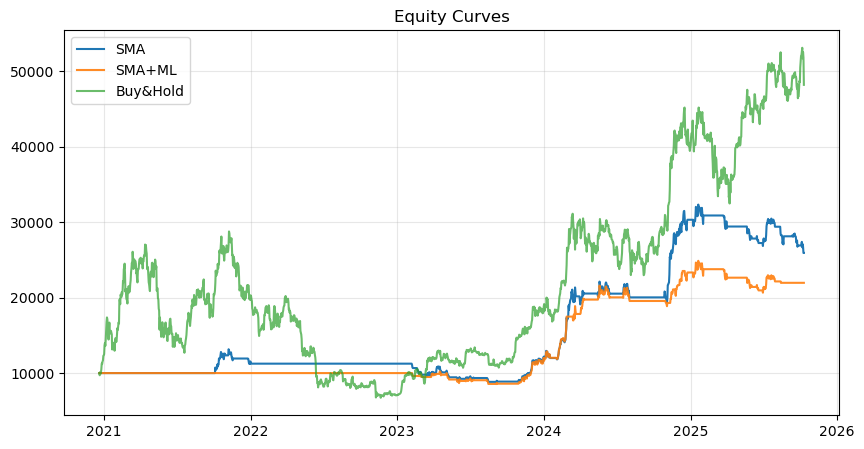


✅ Files ready (XLSX):
 data/sma_equity.xlsx
 data/ml_equity.xlsx
 data/sip_daily_equity.xlsx  data/sip_weekly_equity.xlsx  data/sip_monthly_equity.xlsx
 data/compare_equity.xlsx
 models/sma_ml_model.pkl  models/sma_ml_scaler.pkl  models/sma_ml_meta.json

=== Sensitivity (ML threshold × fees) ===
 ML_thresh  fee_bps  exposure  trades   Sharpe  Sortino     CAGR     MaxDD        Final
      0.45        5  0.192483      51 0.856888 0.822716 0.123675 -0.168088 22535.970685
      0.45       10  0.192483      51 0.832270 0.797273 0.119570 -0.169770 21968.531490
      0.45       15  0.192483      51 0.807588 0.770515 0.115478 -0.171449 21415.106672
      0.50        5  0.107062      39 0.820815 0.624303 0.098365 -0.112082 19227.994929
      0.50       10  0.107062      39 0.798204 0.605574 0.095297 -0.113426 18856.818574
      0.50       15  0.107062      39 0.775520 0.584054 0.092236 -0.114768 18492.627046
      0.55        5  0.035877      29 0.590106 0.277715 0.041129 -0.092390 13242.72482

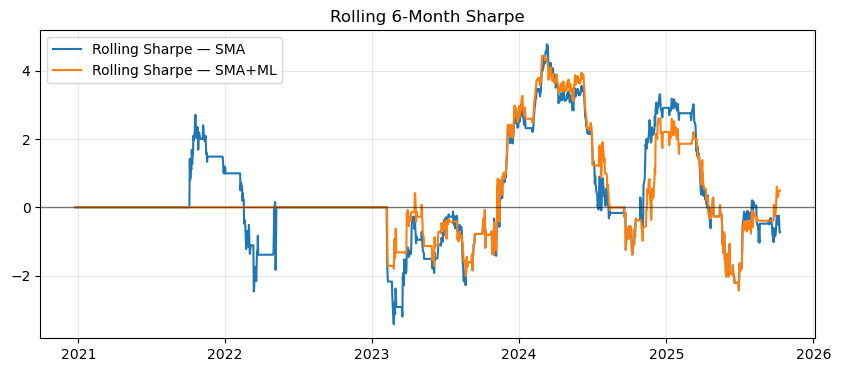

In [51]:
# ============================================
# SMA(10/20) BOT + SIP + ML FILTER + WALK-FORWARD
# + ROBUSTNESS PACK (sensitivity, feature importance, trades, rolling Sharpe)
# ============================================

# ---- Change just this path to your Excel file ----
INPUT_XLSX = "feat_daily_clean.xlsx"   # e.g. r"C:\Users\me\btc.xlsx"

# ---- Imports ----
import os, json, joblib, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,5)

ANNUALIZATION = 252
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

# ---------------- Helpers ----------------
def sharpe(r, ann=ANNUALIZATION):
    r = pd.Series(r).dropna()
    s = r.std()
    return 0.0 if s == 0 or np.isnan(s) else (r.mean()/s)*np.sqrt(ann)

def sortino(r, ann=ANNUALIZATION):
    r = pd.Series(r).dropna()
    dn = r[r<0].std()
    return 0.0 if dn == 0 or np.isnan(dn) else (r.mean()/dn)*np.sqrt(ann)

def max_dd(eq):
    e = pd.Series(eq).astype(float)
    dd = e/e.cummax() - 1.0
    return float(dd.min())

def cagr(eq, ann=ANNUALIZATION):
    e = pd.Series(eq).astype(float)
    return (e.iloc[-1]/e.iloc[0])**(ann/len(e))-1

def profit_factor(returns):
    r = pd.Series(returns)
    gains = r[r>0].sum()
    losses = -r[r<0].sum()
    return np.nan if losses==0 else gains/losses

def rsi(series, length=14):
    chg = series.diff()
    up  = chg.clip(lower=0).rolling(length).mean()
    dn  = -chg.clip(upper=0).rolling(length).mean()
    rs  = up/dn
    return 100 - (100/(1+rs))

def vol_gate(series, window=20, threshold=0.08):
    vol = series.pct_change().rolling(window).std()
    return (vol < threshold).fillna(False).values

def step_splits(n, train_min=500, val=120, test=120, step=120):
    """Yield (train slice, val slice, test slice) indices."""
    start = 0
    while True:
        tr_end = start + train_min
        va_end = tr_end + val
        te_end = va_end + test
        if te_end > n: break
        yield np.arange(start, tr_end), np.arange(tr_end, va_end), np.arange(va_end, te_end)
        start += step

# ---------------- Load data ----------------
df = pd.read_excel(INPUT_XLSX, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
req = ["Date","Open","High","Low","Close","Volume"]
miss = [c for c in req if c not in df.columns]
if miss: raise ValueError(f"Missing columns in Excel: {miss}")

# ---------------- Feature engineering ----------------
df["SMA10"] = df["Close"].rolling(10).mean()
df["SMA20"] = df["Close"].rolling(20).mean()
df["SMA_gap"] = (df["SMA10"] - df["SMA20"]) / df["SMA20"]
df["RSI14"] = rsi(df["Close"], 14)

df["Ret1"]  = df["Close"].pct_change()
df["Ret5"]  = df["Close"].pct_change(5)
df["Ret10"] = df["Close"].pct_change(10)
df["Vol10"] = df["Ret1"].rolling(10).std()
df["Vol20"] = df["Ret1"].rolling(20).std()
df = df.dropna().reset_index(drop=True)

# ---------------- SMA crossover BUY/SELL ----------------
above = df["SMA10"] > df["SMA20"]
cross_up   = (above & (~above.shift(1).fillna(False))).astype(int)
cross_down = ((~above) & (above.shift(1).fillna(False))).astype(int)

pos = np.zeros(len(df), dtype=int)
in_pos = 0
for i in range(len(df)):
    if cross_up.iloc[i]==1: in_pos = 1
    if cross_down.iloc[i]==1: in_pos = 0
    pos[i] = in_pos
df["SMA_Pos"] = pos

# ---------------- Backtest SMA (fees, stops, trend, vol gate) ----------------
INIT = 10_000
FEE_BPS = 10                # 10 bps per entry
FEE = FEE_BPS/10000.0
USE_TREND = True            # only trade when 50SMA > 200SMA
USE_VOL_GATE = True         # only when vol < threshold
VOL_THRESHOLD = 0.08        # 8% daily stdev 20D
DAILY_STOP = 0.03           # 3% daily stop cap

trend = (df["Close"].rolling(50).mean() > df["Close"].rolling(200).mean()).fillna(False).values
if not USE_TREND: trend = np.ones(len(df), dtype=bool)
gate = vol_gate(df["Close"], window=20, threshold=VOL_THRESHOLD) if USE_VOL_GATE else np.ones(len(df), dtype=bool)

raw_pos = df["SMA_Pos"].values * trend * gate
turn_on = (pd.Series(raw_pos).diff().fillna(0) > 0).astype(int).values

ret_next = df["Close"].pct_change().shift(-1).fillna(0.0).values
ret_next = np.maximum(ret_next, -DAILY_STOP)  # stop cap

net   = ret_next - FEE*turn_on
strat = raw_pos * net

sma_eq = INIT*(1+pd.Series(strat)).cumprod()
bh_eq  = INIT*(df["Close"]/df["Close"].iloc[0])

turnover = np.sum(np.abs(np.diff(raw_pos))) / len(raw_pos)
sma_stats = {
    "trades": int(turn_on.sum()),
    "exposure": float(np.mean(raw_pos)),
    "hit_rate": float(np.mean(ret_next[raw_pos==1] > 0)) if np.any(raw_pos==1) else 0.0,
    "turnover": float(turnover),
    "profit_factor": float(profit_factor(strat)),
    "sharpe": float(sharpe(strat)),
    "sortino": float(sortino(strat)),
    "cagr": float(cagr(sma_eq)),
    "maxDD": float(max_dd(sma_eq)),
    "final": float(sma_eq.iloc[-1]),
}
print("SMA BOT:", {k:(f"{v:.2%}" if k in ["exposure","hit_rate","turnover","cagr","maxDD"] else round(v,4))
                  for k,v in sma_stats.items()})

# Save for app (now as XLSX)
sma_out = pd.DataFrame({"Date": df["Date"], "SMA_Position": raw_pos,
                        "StratEquity": sma_eq.values, "BuyHoldEquity": bh_eq.values})
sma_out.to_excel("data/sma_equity.xlsx", index=False, engine="openpyxl")

# ---------------- SIP backtests ----------------
def sip(price_df, contribution=1000, freq="M"):
    d = price_df[["Date","Close"]].copy()
    inv_dates = d.set_index("Date").resample(freq).last().index
    mask = d["Date"].isin(inv_dates)
    d["Units"] = np.where(mask, contribution/d["Close"], 0.0).cumsum()
    d["ContribCum"] = np.where(mask, contribution, 0.0).cumsum()
    d["Equity"] = d["Units"] * d["Close"]
    return d[["Date","Equity","ContribCum"]]

price = df[["Date","Close"]].copy()
sip_D = sip(price, 100, "D");  sip_D.to_excel("data/sip_daily_equity.xlsx", index=False, engine="openpyxl")
sip_W = sip(price, 300, "W");  sip_W.to_excel("data/sip_weekly_equity.xlsx", index=False, engine="openpyxl")
sip_M = sip(price, 1000,"M");  sip_M.to_excel("data/sip_monthly_equity.xlsx", index=False, engine="openpyxl")

compare = (sma_out[["Date","StratEquity"]].rename(columns={"StratEquity":"SMA"})
           .merge(sip_M[["Date","Equity"]].rename(columns={"Equity":"SIP_M"}), on="Date", how="outer")
           .merge(pd.DataFrame({"Date":df["Date"], "BuyHold": bh_eq}), on="Date", how="outer")
           .sort_values("Date").ffill())
compare.to_excel("data/compare_equity.xlsx", index=False, engine="openpyxl")

# ---------------- LIGHT ML FILTER + WALK-FORWARD ----------------
df["UpNext"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
FEATURES = ["SMA_gap","RSI14","Ret1","Ret5","Ret10","Vol10","Vol20"]
X_all = df[FEATURES].astype("float32").values
y_all = df["UpNext"].values

probs = np.full(len(df), np.nan)
last_scaler, last_lr = None, None

for tr, va, te in step_splits(len(df), train_min=500, val=120, test=120, step=120):
    scaler = StandardScaler().fit(X_all[tr])
    Xtr = scaler.transform(X_all[tr])
    Xva = scaler.transform(X_all[va])
    Xte = scaler.transform(X_all[te])
    ytr, yva = y_all[tr], y_all[va]

    lr = LogisticRegression(max_iter=2000, class_weight="balanced")
    lr.fit(Xtr, ytr)
    p_va = lr.predict_proba(Xva)[:,1]
    p_te = lr.predict_proba(Xte)[:,1]

    iso = IsotonicRegression(out_of_bounds="clip").fit(p_va, yva)
    probs[te] = iso.predict(p_te)

    last_scaler, last_lr = scaler, lr  # keep last fitted models

df["ML_Prob"] = probs

ML_THRESH = 0.45  # tweak here for more/less exposure
ml_pos = ((raw_pos==1) & (df["ML_Prob"] > ML_THRESH)).astype(int).values
ml_turn_on = (pd.Series(ml_pos).diff().fillna(0) > 0).astype(int).values

ret_next2 = df["Close"].pct_change().shift(-1).fillna(0.0).values
ret_next2 = np.maximum(ret_next2, -DAILY_STOP)

net2   = ret_next2 - FEE*ml_turn_on
strat2 = ml_pos * net2
ml_eq  = INIT*(1+pd.Series(strat2)).cumprod()

ml_stats = {
    "trades": int(ml_turn_on.sum()),
    "exposure": float(np.mean(ml_pos)),
    "hit_rate": float(np.mean(ret_next2[ml_pos==1] > 0)) if np.any(ml_pos==1) else 0.0,
    "turnover": float(np.sum(np.abs(np.diff(ml_pos))) / len(ml_pos)),
    "profit_factor": float(profit_factor(strat2)),
    "sharpe": float(sharpe(strat2)),
    "sortino": float(sortino(strat2)),
    "cagr": float(cagr(ml_eq)),
    "maxDD": float(max_dd(ml_eq)),
    "final": float(ml_eq.iloc[-1]),
}
print("SMA + ML FILTER:", {k:(f"{v:.2%}" if k in ["exposure","hit_rate","turnover","cagr","maxDD"] else round(v,4))
                           for k,v in ml_stats.items()})

joblib.dump(last_scaler, "models/sma_ml_scaler.pkl")
joblib.dump(last_lr,     "models/sma_ml_model.pkl")
with open("models/sma_ml_meta.json","w") as f:
    json.dump({"features":FEATURES,"threshold":ML_THRESH}, f, indent=2)

ml_out = pd.DataFrame({"Date": df["Date"], "ML_Prob": df["ML_Prob"],
                       "ML_Position": ml_pos, "StratEquity": ml_eq, "BuyHoldEquity": bh_eq})
ml_out.to_excel("data/ml_equity.xlsx", index=False, engine="openpyxl")

# ---------------- Quick equity plot ----------------
plt.plot(df["Date"], sma_eq, label="SMA")
plt.plot(df["Date"], ml_eq, label="SMA+ML", alpha=0.9)
plt.plot(df["Date"], bh_eq, label="Buy&Hold", alpha=0.7)
plt.title("Equity Curves")
plt.legend(); plt.grid(alpha=0.3); plt.show()

print("\n✅ Files ready (XLSX):")
print(" data/sma_equity.xlsx")
print(" data/ml_equity.xlsx")
print(" data/sip_daily_equity.xlsx  data/sip_weekly_equity.xlsx  data/sip_monthly_equity.xlsx")
print(" data/compare_equity.xlsx")
print(" models/sma_ml_model.pkl  models/sma_ml_scaler.pkl  models/sma_ml_meta.json")

# =========================================================
# ROBUSTNESS PACK — sensitivity, feature importance, trades, rolling Sharpe
# =========================================================

# 1) Sensitivity: ML threshold × fees
thr_grid = np.round(np.arange(0.45, 0.66, 0.05), 2)   # 0.45..0.65
fee_bps_grid = [5, 10, 15]
sens_rows = []

base_ret = df["Close"].pct_change().shift(-1).fillna(0.0).values
base_ret = np.maximum(base_ret, -DAILY_STOP)

for thr in thr_grid:
    for fb in fee_bps_grid:
        fee_local = fb/10000.0
        pos_local = ((raw_pos==1) & (df["ML_Prob"] > thr)).astype(int).values
        turn_local = (pd.Series(pos_local).diff().fillna(0) > 0).astype(int).values
        net_local = base_ret - fee_local*turn_local
        strat_local = pos_local * net_local
        eq_local = INIT*(1+pd.Series(strat_local)).cumprod()
        sens_rows.append({
            "ML_thresh": thr,
            "fee_bps": fb,
            "exposure": pos_local.mean(),
            "trades": int(turn_local.sum()),
            "Sharpe": sharpe(strat_local),
            "Sortino": sortino(strat_local),
            "CAGR": cagr(eq_local),
            "MaxDD": max_dd(eq_local),
            "Final": float(eq_local.iloc[-1]),
        })

sens = pd.DataFrame(sens_rows).sort_values(["ML_thresh","fee_bps"]).reset_index(drop=True)
print("\n=== Sensitivity (ML threshold × fees) ===")
print(sens.head(12).to_string(index=False))
sens.to_excel("data/sensitivity_ml_thresh_fee.xlsx", index=False, engine="openpyxl")
print("Saved: data/sensitivity_ml_thresh_fee.xlsx")

# 2) Feature importance (logistic coefficients on scaled features)
# Refit a scaler on the last train window already stored as last_scaler/last_lr
coef_series = pd.Series(last_lr.coef_.ravel(), index=FEATURES).sort_values(key=np.abs, ascending=False)
print("\n=== Logistic coefficients (scaled inputs) ===")
print(coef_series.round(3))
coef_series.to_frame("coef").to_excel("data/ml_feature_importance.xlsx", index=True, engine="openpyxl")
print("Saved: data/ml_feature_importance.xlsx")

# 3) Trade log (SMA+ML) — buy/sell markers with reasons
price_vals = df["Close"].values
sig = ml_pos
chg = pd.Series(sig).diff().fillna(0).astype(int).values
events = []
for i in range(len(df)):
    if chg[i] == 1:
        events.append({"Date": df["Date"].iloc[i], "Type": "BUY",
                       "Price": price_vals[i],
                       "SMA10": df["SMA10"].iloc[i], "SMA20": df["SMA20"].iloc[i],
                       "ML_Prob": float(df["ML_Prob"].iloc[i])})
    elif chg[i] == -1:
        events.append({"Date": df["Date"].iloc[i], "Type": "SELL",
                       "Price": price_vals[i],
                       "SMA10": df["SMA10"].iloc[i], "SMA20": df["SMA20"].iloc[i],
                       "ML_Prob": float(df["ML_Prob"].iloc[i])})
trades = pd.DataFrame(events)
print(f"\n=== Trades (SMA+ML) — {len(trades)} rows ===")
print(trades.head().to_string(index=False))
trades.to_excel("data/trades_sma_ml.xlsx", index=False, engine="openpyxl")
print("Saved: data/trades_sma_ml.xlsx")

# 4) Rolling Sharpe (6 months ≈ 126 bars)
def rolling_sharpe(r, win=126):
    out = []
    for i in range(len(r)):
        a = r[max(0, i-win+1):i+1]
        out.append(sharpe(a) if len(a)>5 else np.nan)
    return pd.Series(out, index=df["Date"])

sma_ret = pd.Series(strat).fillna(0.0)
ml_ret  = pd.Series(strat2).fillna(0.0)
rs_sma = rolling_sharpe(sma_ret)
rs_ml  = rolling_sharpe(ml_ret)

plt.figure(figsize=(10,4))
plt.plot(df["Date"], rs_sma, label="Rolling Sharpe — SMA")
plt.plot(df["Date"], rs_ml,  label="Rolling Sharpe — SMA+ML")
plt.axhline(0, lw=1, alpha=0.5, color="k")
plt.title("Rolling 6-Month Sharpe"); plt.legend(); plt.grid(alpha=0.3); plt.show()


In [55]:
import pandas as pd
import os

data_dir = "data"   # folder containing your Excel files
files = [f for f in os.listdir(data_dir) if f.endswith(".xlsx")]

print("🔍 Checking Excel files in ./data for NaN values:\n")

for file in files:
    path = os.path.join(data_dir, file)
    try:
        df = pd.read_excel(path)
        nans = df.isna().sum().sum()
        if nans > 0:
            print(f"⚠️  {file} has {nans:,} missing values")
            print(df.isna().sum())
            print("-" * 60)
        else:
            print(f"✅ {file} — no missing values")
    except Exception as e:
        print(f"❌ Could not read {file}: {e}")

print("\nDone.")


🔍 Checking Excel files in ./data for NaN values:

✅ compare_equity.xlsx — no missing values
⚠️  ml_equity.xlsx has 676 missing values
Date               0
ML_Prob          676
ML_Position        0
StratEquity        0
BuyHoldEquity      0
dtype: int64
------------------------------------------------------------
✅ ml_feature_importance.xlsx — no missing values
✅ oos_predictions.xlsx — no missing values
✅ sensitivity_ml_thresh_fee.xlsx — no missing values
✅ sip_daily_equity.xlsx — no missing values
✅ sip_monthly_equity.xlsx — no missing values
✅ sip_weekly_equity.xlsx — no missing values
✅ sma_equity.xlsx — no missing values
⚠️  trades_sma_ml.xlsx has 1 missing values
Date       0
Type       0
Price      0
SMA10      0
SMA20      0
ML_Prob    1
dtype: int64
------------------------------------------------------------

Done.


In [57]:
import pandas as pd, numpy as np, joblib, os

# === CONFIG ===
PRICE_XLSX = "feat_daily_clean.xlsx"   # your Yahoo data
ML_EQUITY_PATH = "data/ml_equity.xlsx"
OUT_ML_FILLED  = "data/ml_equity_filled.xlsx"

SCALER_PATH = "models/sma_ml_scaler.pkl"
MODEL_PATH  = "models/sma_ml_model.pkl"

# ---- Helpers ----
def rsi(series, length=14):
    chg = series.diff()
    up  = chg.clip(lower=0).rolling(length).mean()
    dn  = -chg.clip(upper=0).rolling(length).mean()
    rs  = up / dn
    return 100 - (100/(1+rs))

def build_feature_frame(price_df):
    df = price_df.copy().sort_values("Date").reset_index(drop=True)
    if "Close" not in df.columns:
        raise ValueError("Data must contain a 'Close' column.")
    # Build features
    df["SMA10"] = df["Close"].rolling(10).mean()
    df["SMA20"] = df["Close"].rolling(20).mean()
    df["SMA_gap"] = (df["SMA10"] - df["SMA20"]) / df["SMA20"]
    df["RSI14"] = rsi(df["Close"], 14)
    df["Ret1"]  = df["Close"].pct_change()
    df["Ret5"]  = df["Close"].pct_change(5)
    df["Ret10"] = df["Close"].pct_change(10)
    df["Vol10"] = df["Ret1"].rolling(10).std()
    df["Vol20"] = df["Ret1"].rolling(20).std()
    df = df.dropna().reset_index(drop=True)
    feats = ["Date","SMA_gap","RSI14","Ret1","Ret5","Ret10","Vol10","Vol20"]
    return df[feats]

# ---- 1. Load your Yahoo file ----
df_price = pd.read_excel(PRICE_XLSX, parse_dates=["Date"])
print(f"✅ Loaded {len(df_price)} rows from {PRICE_XLSX}")

# ---- 2. Build features ----
feat_df = build_feature_frame(df_price)
FEATURES = ["SMA_gap","RSI14","Ret1","Ret5","Ret10","Vol10","Vol20"]

# ---- 3. Load model artifacts ----
if not (os.path.exists(SCALER_PATH) and os.path.exists(MODEL_PATH)):
    raise FileNotFoundError("⚠️ Model files not found. Run training first.")
scaler = joblib.load(SCALER_PATH)
model  = joblib.load(MODEL_PATH)

# ---- 4. Load ml_equity.xlsx ----
ml_eq = pd.read_excel(ML_EQUITY_PATH, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
merged = ml_eq.merge(feat_df, on="Date", how="left")

# ---- 5. Predict ML_Prob wherever features exist ----
X_mask = merged[FEATURES].notna().all(axis=1)
X = merged.loc[X_mask, FEATURES].astype("float32").values
probs = model.predict_proba(scaler.transform(X))[:,1]
merged.loc[X_mask, "ML_Prob"] = probs

# ---- 6. Fill edges and save ----
merged["ML_Prob"] = merged["ML_Prob"].fillna(method="ffill").fillna(method="bfill")
merged.to_excel(OUT_ML_FILLED, index=False)
print(f"✅ Saved clean ML probabilities → {OUT_ML_FILLED}")


✅ Loaded 1776 rows from feat_daily_clean.xlsx
✅ Saved clean ML probabilities → data/ml_equity_filled.xlsx


In [58]:
import pandas as pd

# Load the cleaned ML probabilities
ml = pd.read_excel("data/ml_equity_filled.xlsx", parse_dates=["Date"])
trades = pd.read_excel("data/trades_sma_ml.xlsx", parse_dates=["Date"])

# Merge new ML_Prob values by Date
merged = trades.merge(ml[["Date","ML_Prob"]], on="Date", how="left", suffixes=("","_new"))

# Fill missing ML_Prob using new values
merged["ML_Prob"] = merged["ML_Prob"].fillna(merged["ML_Prob_new"])
merged.drop(columns=["ML_Prob_new"], inplace=True)

# Fill any remaining edges just in case
merged["ML_Prob"] = merged["ML_Prob"].fillna(method="ffill").fillna(method="bfill")

# Save the repaired file
merged.to_excel("data/trades_sma_ml_filled.xlsx", index=False)
print("✅ Saved: data/trades_sma_ml_filled.xlsx (no missing ML_Prob)")


✅ Saved: data/trades_sma_ml_filled.xlsx (no missing ML_Prob)


In [101]:
# Kill any running streamlit & ngrok servers (works on most systems)
import os, signal, psutil

# Kill processes with 'streamlit' in the cmdline
for p in psutil.process_iter(attrs=["pid","name","cmdline"]):
    try:
        cmd = " ".join(p.info.get("cmdline") or [])
        if "streamlit" in cmd.lower():
            p.kill()
    except Exception:
        pass

# Kill any ngrok tunnels
from pyngrok import ngrok
ngrok.kill()

print("Cleaned up prior processes.")


t=2025-10-12T05:57:42-0700 lvl=warn msg="failed to open private leg" id=4a08871a6ce1 privaddr=localhost:8100 err="dial tcp [::1]:8100: connectex: No connection could be made because the target machine actively refused it."
t=2025-10-12T05:57:42-0700 lvl=warn msg="failed to open private leg" id=2572ff809ff7 privaddr=localhost:8100 err="dial tcp [::1]:8100: connectex: No connection could be made because the target machine actively refused it."


Cleaned up prior processes.


In [102]:
# If needed: !pip install pyngrok -q

from pyngrok import ngrok, conf
import os, threading, time, pathlib

# 3a) Set your ngrok auth token ONCE (replace with yours)
conf.get_default().auth_token = ""

# 3b) Absolute path to the file you want to run
APP_PATH = str(pathlib.Path("appy.py").resolve())   # <-- ensure this points to your file
PORT = 8100                                        # fresh port

# 3c) Launch Streamlit for THIS file on that port
def run_streamlit():
    cmd = f'streamlit run "appy.py" --server.headless true --server.port {PORT} --server.fileWatcherType none'
    os.system(cmd)

threading.Thread(target=run_streamlit, daemon=True).start()
time.sleep(5)  # give it a moment to boot

# 3d) Open ngrok tunnel to the same port
public_url = ngrok.connect(PORT)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://77ac71f33fc4.ngrok-free.app" -> "http://localhost:8100"


In [72]:
!python -m pip install --upgrade pip setuptools wheel


Defaulting to user installation because normal site-packages is not writeable
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 24.0 MB/s eta 0:00:00
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [73]:
!pip install -q gpt4all streamlit streamlit-jupyter plotly scikit-learn xlsxwriter pandas numpy joblib


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [79]:
!pip install -q gpt4all huggingface_hub


In [82]:
import os, traceback
from typing import Optional
from huggingface_hub import hf_hub_download
from gpt4all import GPT4All

LOCAL_DIR = "./models"
os.makedirs(LOCAL_DIR, exist_ok=True)

PREFERRED_LOCAL_FILE = os.path.join(LOCAL_DIR, "local_model.gguf")  # optional offline override

CANDIDATES = [
    ("Qwen/Qwen2-0.5B-Instruct-GGUF", "qwen2-0_5b-instruct-q4_k_m.gguf",  "Qwen2 0.5B Instruct (small)"),
    # add more if you like:
    # ("TheBloke/phi-2-GGUF", "phi-2.Q4_K_M.gguf", "Phi-2 (larger, better)"),
]

def resolve_model_file() -> str:
    if os.path.exists(PREFERRED_LOCAL_FILE):
        print(f"Using local model file: {PREFERRED_LOCAL_FILE}")
        return PREFERRED_LOCAL_FILE

    last_err = None
    for repo_id, filename, note in CANDIDATES:
        try:
            print(f"Trying {note} from {repo_id} …")
            path = hf_hub_download(repo_id=repo_id, filename=filename, local_dir=LOCAL_DIR)
            print(f"Downloaded: {path}")
            return path
        except Exception as e:
            last_err = e
            print(f"Failed: {e}")
    raise RuntimeError(
        "Could not obtain a model automatically.\n"
        f"Place any .gguf at: {PREFERRED_LOCAL_FILE} and rerun.\n"
        f"Last error: {last_err}"
    )

def load_llm():
    full_path = resolve_model_file()
    model_name = os.path.basename(full_path)   # e.g. 'qwen2-0_5b-instruct-q4_k_m.gguf'
    model_dir  = os.path.dirname(full_path)    # e.g. './models'
    # IMPORTANT: give model_name (filename) + model_path (directory)
    llm = GPT4All(model_name=model_name, model_path=model_dir, allow_download=False)
    return llm

# --- quick test ---
try:
    llm = load_llm()
    with llm.chat_session():
        out = llm.generate("Explain SMA crossover in one sentence.", temp=0.2, max_tokens=60)
    print("\n✅ Model responded:", out)
except Exception as e:
    print("\n❌ LLM load/generate failed.\n", e)
    traceback.print_exc(limit=2)


Trying Qwen2 0.5B Instruct (small) from Qwen/Qwen2-0.5B-Instruct-GGUF …
Downloaded: models\qwen2-0_5b-instruct-q4_k_m.gguf

✅ Model responded: The term "SMA crossover" refers to the phenomenon where a stock's price moves up and down, with each move being accompanied by a significant change in its direction of movement over time. This can occur due to various factors such as economic indicators, market sentiment, or news events that affect the overall
